In [26]:
#import tensorflow.compat.v1 as tf #'2.16.2'
#tf.enable_eager_execution()
import tensorflow as tf
import deepxde as dde #'1.13.0'

from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt #'3.9.2'
import numpy as np #'1.26.4'
from matplotlib import colormaps as cm
from tqdm import tqdm
import scipy #'1.15.1'

from functools import partial

# Part 1

## Problem 1:

### A simple ODE
Consider the equation $$\frac{dy}{dx} = \cos(\omega x), \quad x\in [-\pi , \pi],$$
with $y(0)=0$.

The exact solution is $y(x)=\frac{1}{\omega}\sin(\omega x)$.


*   Give the approximation to the solution using a PINN for $\omega =2$.
*   Repeat the experiment with $\omega =10$.
* How does the size of $\omega$ affect the training or performance of your PINN?



In [132]:
def exact_solution(x, omega):  # Exact/reference solution
    return (1/omega)*np.sin(omega*x)

Compiling model...
Building feed-forward neural network...
'build' took 1.524721 s

'compile' took 7.305301 s

Training model...

Step      Train loss              Test loss               Test metric
0         [4.55e+00, 0.00e+00]    [4.57e+00, 0.00e+00]    []  
1000      [1.61e-03, 5.76e-09]    [1.59e-03, 5.76e-09]    []  
2000      [6.16e-05, 3.57e-12]    [5.71e-05, 3.57e-12]    []  

Best model at step 2000:
  train loss: 6.16e-05
  test loss: 5.71e-05
  test metric: []

'train' took 17.687619 s

Compiling model...
Building feed-forward neural network...
'build' took 0.300893 s

'compile' took 3.069659 s

Training model...

Step      Train loss              Test loss               Test metric
0         [3.63e+00, 0.00e+00]    [3.66e+00, 0.00e+00]    []  
1000      [3.70e-01, 6.38e-08]    [3.67e-01, 6.38e-08]    []  
2000      [2.91e-01, 1.27e-08]    [2.88e-01, 1.27e-08]    []  

Best model at step 2000:
  train loss: 2.91e-01
  test loss: 2.88e-01
  test metric: []

'train' took 14.

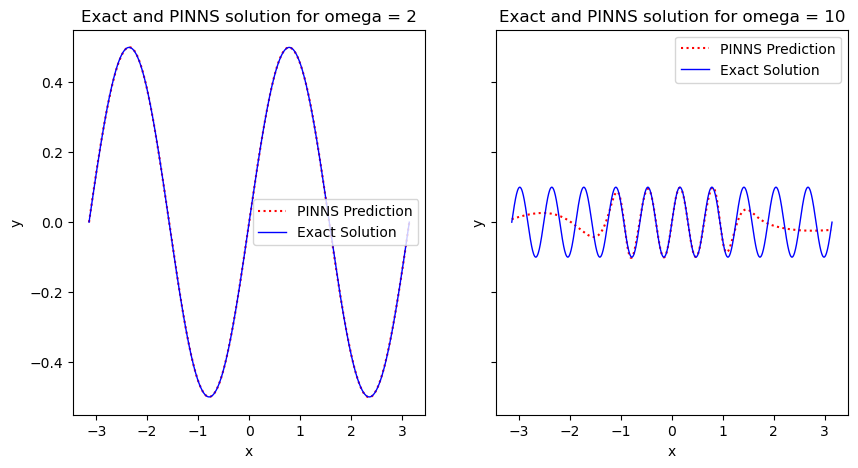

In [134]:
x = np.linspace(-np.pi, np.pi, 1000)
geom = dde.geometry.TimeDomain(x[0], x[-1])

x_begin = 0; y_begin = 0
def boundary_begin(x,_):  # Since the equation is of order one, we only need one boundary/initial condition.
                          # In priciple one coulde apply the initial condion to the solutions by "Hard constrains",
                          # But for this example we decided to use it explicitly as follows:
    return dde.utils.isclose(x[0],x_begin)

def bc_func_begin(x,y,_): 
    
    return y - y_begin

bc1 = dde.icbc.OperatorBC(geom,bc_func_begin,boundary_begin)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)



os = [2,10] #Different values for omega.
for i in [0,1]:
    omega = os[i]
    #ref_solution = partial(exact_solution, omega = omega) # Ref solution
    def ODE_deepxde(x,y):
        dy_dx = dde.grad.jacobian(y,x)
    
        return dy_dx - tf.cos(omega*x)
                
    data = dde.data.PDE(geom, ODE_deepxde,[bc1], 
                        num_domain = 1000,
                        num_boundary = 0, # Note that no boundary points is choosen. This is harmless since the ODE
                                          # is of first order, and we already applied the initial conditions
                        num_test = 200,
                        anchors = None)

    net = dde.nn.FNN([1,30,30,1], 'tanh', 'He uniform')
    
    model = dde.Model(data, net)
    model.compile('adam', lr = 0.001, metrics = [])
    losshistory, train_state = model.train(iterations = 2000, display_every = 1000)
                
    y_pred = model.predict(x[:, None])
    
 
    
    
    ax[i].plot(x, y_pred, color='r',label='PINNS Prediction', ls=':')
    ax[i].plot(x, exact_solution(x, omega = omega), lw=1, color='b', label='Exact Solution')
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    ax[i].set_title('Exact and PINNS solution for omega = {}'.format(omega))            
            
    ax[i].legend()

plt.show()            
    


The plots above shows a very close agreement between the exact solutions and PINNS' results, for both parameter values.

In the following, similar to the GridSearch of SKlearn, we study the dependence of PINNS model accuracy on the interior/boundary points for $\omega = 2$.

In [19]:
# Model accuracy

omega = 2
def ODE_deepxde(x,y):
    dy_dx = dde.grad.jacobian(y,x)
    
    return dy_dx - tf.cos(omega*x)

def acc_par(boundary_points, interior_points, layers, nodes): # We define a function that takes the number of bulk/boundary 
                                               # points, layers and number of neurons in each layer as input.
    b=boundary_points
    i=interior_points
    ref_solution = partial(exact_solution, omega = omega) # Ref solution
    
    data = dde.data.PDE(geom, ODE_deepxde,[bc1], 
                        solution = ref_solution,
                        num_domain = i,
                        num_boundary = b, 
                        num_test = 50 )

    net = dde.nn.FNN([1] + [nodes]*layers + [1], 'tanh', 'He uniform')
   
    model = dde.Model(data, net)
    model.compile('adam', lr = 0.01, metrics = [], verbose=0)
    losshistory, train_state = model.train(iterations = 500, display_every = 500, verbose = 0)
    
    x = np.linspace(-np.pi, np.pi, 100)
    y_pred = model.predict(x[:, None])
    y_true = exact_solution(x, omega)
    
    return dde.metrics.l2_relative_error(y_true,y_pred) # This function returns the error of the PINNs models 
                                                        # relative to the 'true' solution.

# We choose the follwing values for the parameters:

num_b = [0,1,2]  # Boundary points
num_i = [1000, 1200, 1400] # Interior points
num_l = [1,2,3]
num_n = [30,40,50]

acc_i = []
for ni in num_i:
    exs = []
    for i in range(3):
        nb = 2; nl = 1; nn = 30
        exs.append(acc_par(nb,ni,nl,nn))
    acc_i.append(exs)
acc_l = []
for nl in num_l:
    exs = []
    for i in range(3):
        ni = 1000; nb = 2; nn = 30
        exs.append(acc_par(nb,ni,nl,nn))
    acc_l.append(exs)
acc_n = []
for nn in num_n:
    exs = []
    for i in range(3):
        ni = 1000; nb = 2; nl = 1
        exs.append(acc_par(nb,ni,nl,nn))
    acc_n.append(exs)
acc_b = []
for nb in num_b:
    exs = []
    for i in range(3):
        ni = 1000; nl = 1; nn = 30 
        exs.append(acc_par(nb,ni,nl,nn))
    acc_b.append(exs)




Building feed-forward neural network...
'build' took 0.039677 s

Building feed-forward neural network...
'build' took 0.046799 s

Building feed-forward neural network...
'build' took 0.034588 s

Building feed-forward neural network...
'build' took 0.045582 s

Building feed-forward neural network...
'build' took 0.115479 s

Building feed-forward neural network...
'build' took 0.070034 s

Building feed-forward neural network...
'build' took 0.076294 s

Building feed-forward neural network...
'build' took 0.050153 s

Building feed-forward neural network...
'build' took 0.048280 s

Building feed-forward neural network...
'build' took 0.035363 s

Building feed-forward neural network...
'build' took 0.031758 s

Building feed-forward neural network...
'build' took 0.034379 s

Building feed-forward neural network...
'build' took 0.054159 s

Building feed-forward neural network...
'build' took 0.106159 s

Building feed-forward neural network...
'build' took 0.053907 s

Building feed-forward neu

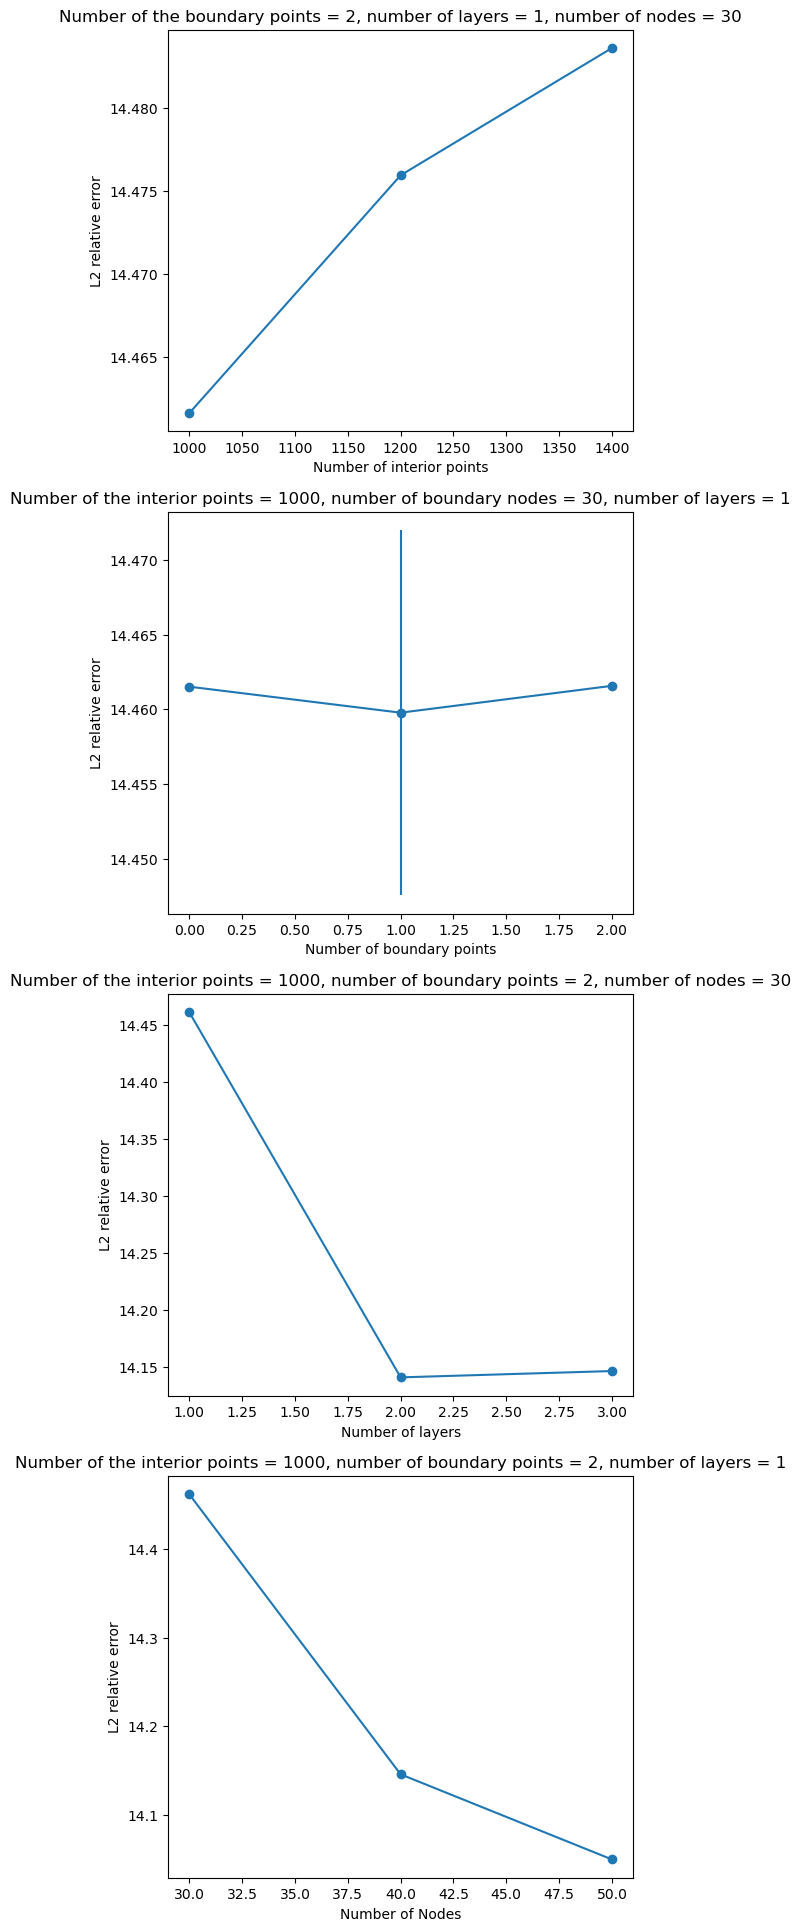

In [83]:
plt.figure(figsize= (6,24))
#plt.suptitle('L2 errors relative to the exact solution for omegra = 2, based on model architecture')

plt.subplot(4,1,1)
stds = np.std(np.array(acc_i), axis = 1)
means= np.mean(np.array(acc_i),axis= 1)
plt.errorbar(x = num_i, y = means, yerr = stds, fmt = '-o')
plt.xlabel('Number of interior points')
plt.ylabel('L2 relative error')
plt.title('Number of the boundary points = 2, number of layers = 1, number of nodes = 30')

plt.subplot(4,1,2)
stds = np.std(np.array(acc_b), axis = 1)
means= np.mean(np.array(acc_b),axis= 1)
plt.errorbar(x = num_b, y = means, yerr = stds, fmt = '-o')
plt.xlabel('Number of boundary points')
plt.ylabel('L2 relative error')
plt.title('Number of the interior points = 1000, number of boundary nodes = 30, number of layers = 1')

plt.subplot(4,1,3)
stds = np.std(np.array(acc_l), axis = 1)
means= np.mean(np.array(acc_l),axis= 1)
plt.errorbar(x = num_l, y = means, yerr = stds, fmt = '-o')
plt.xlabel('Number of layers')
plt.ylabel('L2 relative error')
plt.title('Number of the interior points = 1000, number of boundary points = 2, number of nodes = 30')

plt.subplot(4,1,4)
stds = np.std(np.array(acc_n), axis = 1)
means= np.mean(np.array(acc_n),axis= 1)
plt.errorbar(x = num_n, y = means, yerr = stds, fmt = '-o')
plt.xlabel('Number of Nodes')
plt.ylabel('L2 relative error')
plt.title('Number of the interior points = 1000, number of boundary points = 2, number of layers = 1')

plt.show()


So from the graphs shown above, the optimal parameters for the interior points is 1000, number boundary points doesn't have a huge effect (due to the large error bar), two layers and 50 neurons in each layer. Note that these number are for a fixed $\omega = 2$.

## Problem 2: 

### Heat equation

Consider the heat equation $$w_t - aw_{xx}=0,\qquad (x,t)\in (0,1)\times (0,1),$$
with initial condition
$$ w(x,0) = x^2+1,$$
and boundary conditions
$$ w(0,t) = 2at + 1\qquad \text{and}\qquad w(1,t)= 2at +2.$$
The exact solution is
$$w(x,t)=x^2 +2at+1.$$


*   Give the approximation to the solution using a PINN for $a =1$.
*   Repeat the experiment with $a =0.01, 10$.



In [5]:
def exact_solution(z, a):
    t = z[:,0:1]
    x = z[:,1:2]
    return x**2 + 2*a*t + 1

x = np.linspace(0,1,100)
t = np.linspace(0,1,100)

X, T = np.meshgrid(x, t)

In [7]:
geom = dde.geometry.Rectangle((0,0), (1, 1))


x_begin = 0; x_end = 1
def boundary_bottom(z,on_boundary):  
    return dde.utils.isclose(z[1],x_begin)


def boundary_top(z,on_boundary):  
    return dde.utils.isclose(z[1],x_end)


def ic_begin(z,on_boundary):
    return dde.utils.isclose(z[0],0)




As = [1,0.01,10]
preds = []
for i in [0,1,2]:
    a = As[i]
    
    ref_solution = partial(exact_solution, a = a) # Ref solution
    
    bc_bottom = dde.icbc.DirichletBC (geom, lambda z: 2*a*z[:,0:1] + 1, boundary_bottom)
    bc_top    = dde.icbc.DirichletBC (geom, lambda z: 2*a*z[:,0:1] + 2, boundary_top)
    bc_ic     = dde.icbc.DirichletBC (geom, lambda z: (z[:,1:2])**2 + 1, ic_begin)
    
    def HEAT_deepxde(z,w):
        dw_dt = dde.grad.jacobian(w,z,0,0)
        dw_dx = dde.grad.jacobian(w,z,0,1)
        d2w_dx2 = dde.grad.jacobian(dw_dx,z,0,1)
    
        return dw_dt - a * d2w_dx2
    
    
    data = dde.data.PDE(geom, HEAT_deepxde,[bc_top,bc_bottom,bc_ic],
                        solution = ref_solution,
                        num_domain = 1000,
                        num_boundary = 6,
                        num_test =50
                       )
    
    net = dde.nn.FNN([2] + [60]*4 + [1], 'tanh', 'He uniform')
    
    model = dde.Model(data, net)
    model.compile('adam', lr = 0.001, metrics = [])
    losshistory, train_state = model.train(iterations = 1000, display_every = 1000)
    
    w_pred = model.predict(np.stack((T.ravel(), X.ravel()), axis=-1)).reshape(len(t), len(x))
    
    preds.append(w_pred)
    
    


Compiling model...
Building feed-forward neural network...
'build' took 0.129795 s

'compile' took 1.093993 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.26e+02, 2.75e+01, 5.05e+00, 7.48e+00]    [1.11e+02, 2.75e+01, 5.05e+00, 7.48e+00]    []  
1000      [1.77e-03, 2.28e-04, 1.72e-04, 3.46e-07]    [9.93e-04, 2.28e-04, 1.72e-04, 3.46e-07]    []  

Best model at step 1000:
  train loss: 2.17e-03
  test loss: 1.39e-03
  test metric: []

'train' took 18.929338 s

Compiling model...
Building feed-forward neural network...
'build' took 0.096557 s

'compile' took 0.605729 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [4.65e-01, 1.39e+01, 2.21e+00, 7.48e+00]    [3.93e-01, 1.39e+01, 2.21e+00, 7.48e+00]    []  
1000      [3.52e-04, 1.42e-05, 1.02e-05, 4.52e-07]    [1.41e-04, 1.42e-05, 1.02e-05, 4.52e-07] 

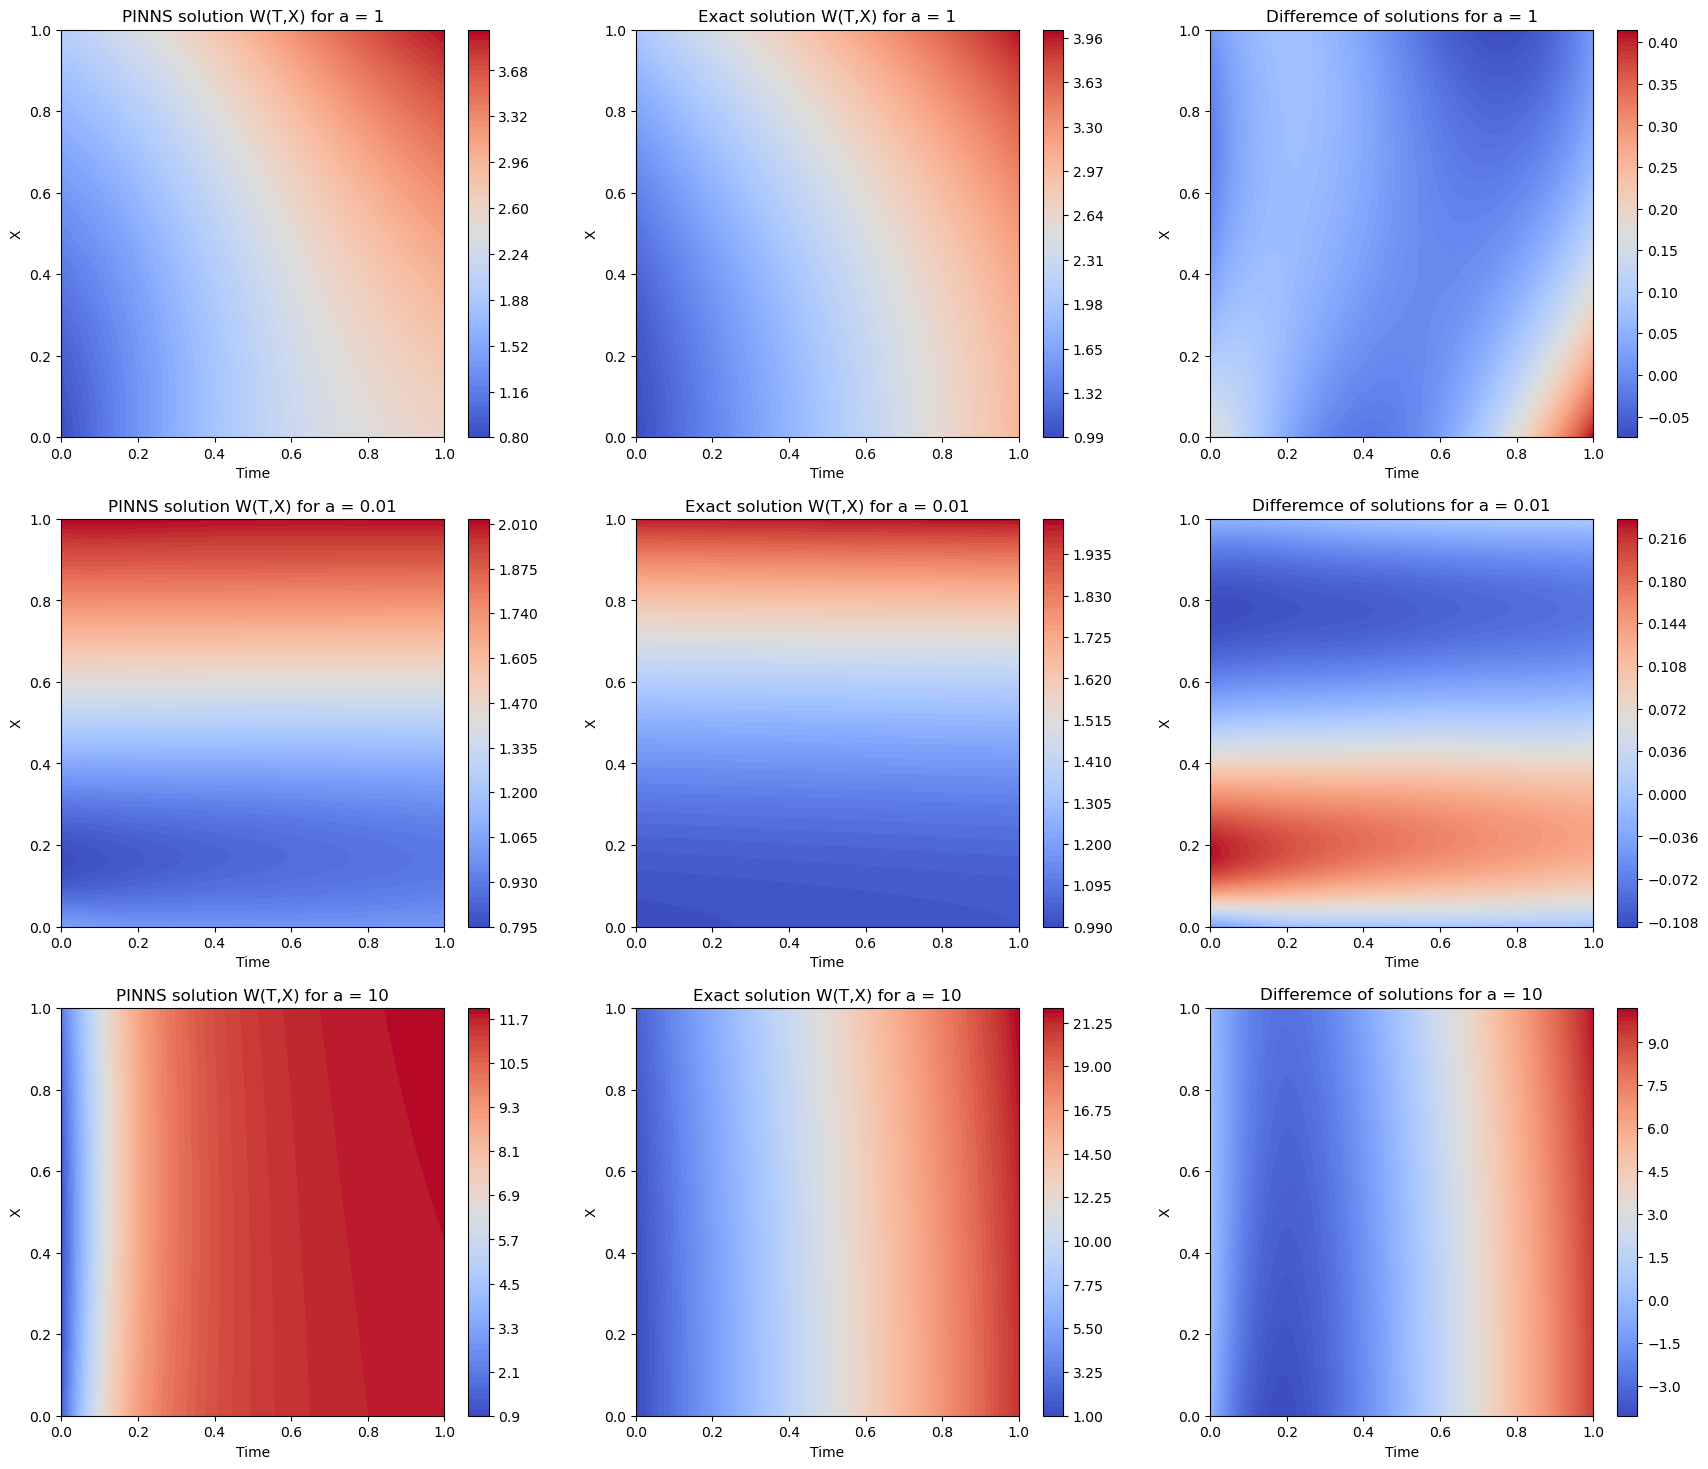

In [9]:
def exact_solution(t,x, a):

    return x**2 + 2*a*t + 1

x = np.linspace(0,1,100)
t = np.linspace(0,1,100)

X, T = np.meshgrid(x, t)

fig, ax  = plt.subplots(3,3 , figsize = (21,18))

for i in range(len(As)):
    a = As[i]
    w_pred = preds [i]
    
   

    im = ax[i,0].contourf(T, X, w_pred, cmap="coolwarm", levels=100)
    ax[i,0].set_xlabel('Time')
    ax[i,0].set_ylabel('X')
    ax[i,0].set_title('PINNS solution W(T,X) for a = {}'.format(a))  
    fig.colorbar(im, ax = ax[i,0])

    im = ax[i,1].contourf(T, X, exact_solution(T,X,a), cmap="coolwarm", levels=100)
    ax[i,1].set_xlabel('Time')
    ax[i,1].set_ylabel('X')
    ax[i,1].set_title('Exact solution W(T,X) for a = {}'.format(a))
    fig.colorbar(im, ax = ax[i,1])

    im = ax[i,2].contourf(T, X, exact_solution(T,X,a) - w_pred, cmap="coolwarm", levels=100)
    ax[i,2].set_xlabel('Time')
    ax[i,2].set_ylabel('X')
    ax[i,2].set_title('Differemce of solutions for a = {}'.format(a))
    fig.colorbar(im, ax = ax[i,2])
    
plt.show()

In [19]:
T.shape

(100, 100)

Overall it seems the PINNs solution is pretty close to the actual solution. However, the value of the test/train loss for $a=10$ is 4 orders higher than the corresponding numbers for $a=1, 0.1$. This is also clear from the graphs that the final case ($a=10$) is not as precise as the others.

In [24]:
# Model accuracy study: (similar to the previous question)
a=1 # Fix the value of a.

geom = dde.geometry.Rectangle((0,0), (1, 1))

x_begin = 0; x_end = 1
def boundary_bottom(z,on_boundary):  
    return dde.utils.isclose(z[1],x_begin)

def boundary_top(z,on_boundary):  
    return dde.utils.isclose(z[1],x_end)

def ic_begin(z,on_boundary):
    return dde.utils.isclose(z[0],0)

bc_bottom = dde.icbc.DirichletBC (geom, lambda z: 2*a*z[:,0:1] + 1, boundary_bottom)
bc_top    = dde.icbc.DirichletBC (geom, lambda z: 2*a*z[:,0:1] + 2, boundary_top)
bc_ic     = dde.icbc.DirichletBC (geom, lambda z: (z[:,1:2])**2 + 1, ic_begin)

ref_solution = partial(exact_solution, a = a) # Ref solution

def HEAT_deepxde(z,w):
    dw_dt = dde.grad.jacobian(w,z,0,0)
    dw_dx = dde.grad.jacobian(w,z,0,1)
    d2w_dx2 = dde.grad.jacobian(dw_dx,z,0,1)
    
    return dw_dt - a * d2w_dx2

def acc_par(boundary_points, interior_points, layer, nodes):
    b=boundary_points
    i=interior_points
      
    
    data = dde.data.PDE(geom, HEAT_deepxde,[bc_top,bc_bottom,bc_ic], 
                        solution = ref_solution,
                        num_domain = i,
                        num_boundary = b,
                       num_test = 50)
    
    net = dde.nn.FNN([2] + [nodes]*layer + [1], 'tanh', 'He uniform')
    
    model = dde.Model(data, net)
    model.compile('adam', lr = 0.01, metrics = [])
    losshistory, train_state = model.train(iterations = 500, display_every = 500)
    
    w_pred = model.predict(np.stack((T.ravel(), X.ravel()), axis=-1)).reshape(len(t), len(x))
    w_true = exact_solution(np.stack((T.ravel(), X.ravel()), axis=-1), a).reshape(len(t), len(x))
    
    return dde.metrics.l2_relative_error(w_true,w_pred)

num_b = [5,6,7]  # Boundary points
num_i = [1000, 1200, 1500] # Interior points
num_l = [1,2,3]
num_n = [30,40,50]

acc_i = []
for ni in num_i:
    nb = 5; nl = 1; nn = 30
    acc_i.append(acc_par(nb,ni,nl,nn))
acc_l = []
for nl in num_l:
    ni = 1000; nb = 5; nn = 30
    acc_l.append(acc_par(nb,ni,nl,nn))
acc_n = []
for nn in num_n:
    ni = 1000; nb = 5; nl = 1
    acc_n.append(acc_par(nb,ni,nl,nn))
acc_b = []
for nb in num_b:
    ni = 1000; nl = 1; nn = 30 
    acc_b.append(acc_par(nb,ni,nl,nn))


Compiling model...
Building feed-forward neural network...
'build' took 0.029406 s

'compile' took 0.627244 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [8.62e+00, 1.43e+01, 4.41e-01, 6.06e+00]    [8.89e+00, 1.43e+01, 4.41e-01, 6.06e+00]    []  
500       [2.69e-03, 1.61e-03, 1.85e-05, 5.32e-05]    [1.61e-03, 1.61e-03, 1.85e-05, 5.32e-05]    []  

Best model at step 500:
  train loss: 4.37e-03
  test loss: 3.29e-03
  test metric: []

'train' took 1.520518 s

Compiling model...
Building feed-forward neural network...
'build' took 0.046097 s

'compile' took 0.667782 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.67e-01, 1.47e+01, 3.25e+00, 2.18e+00]    [2.44e-01, 1.47e+01, 3.25e+00, 2.18e+00]    []  
500       [9.40e-03, 2.86e-03, 1.94e-05, 2.09e-05]    [5.27e-03, 2.86e-03, 1.94e-05, 2.09e-05]   

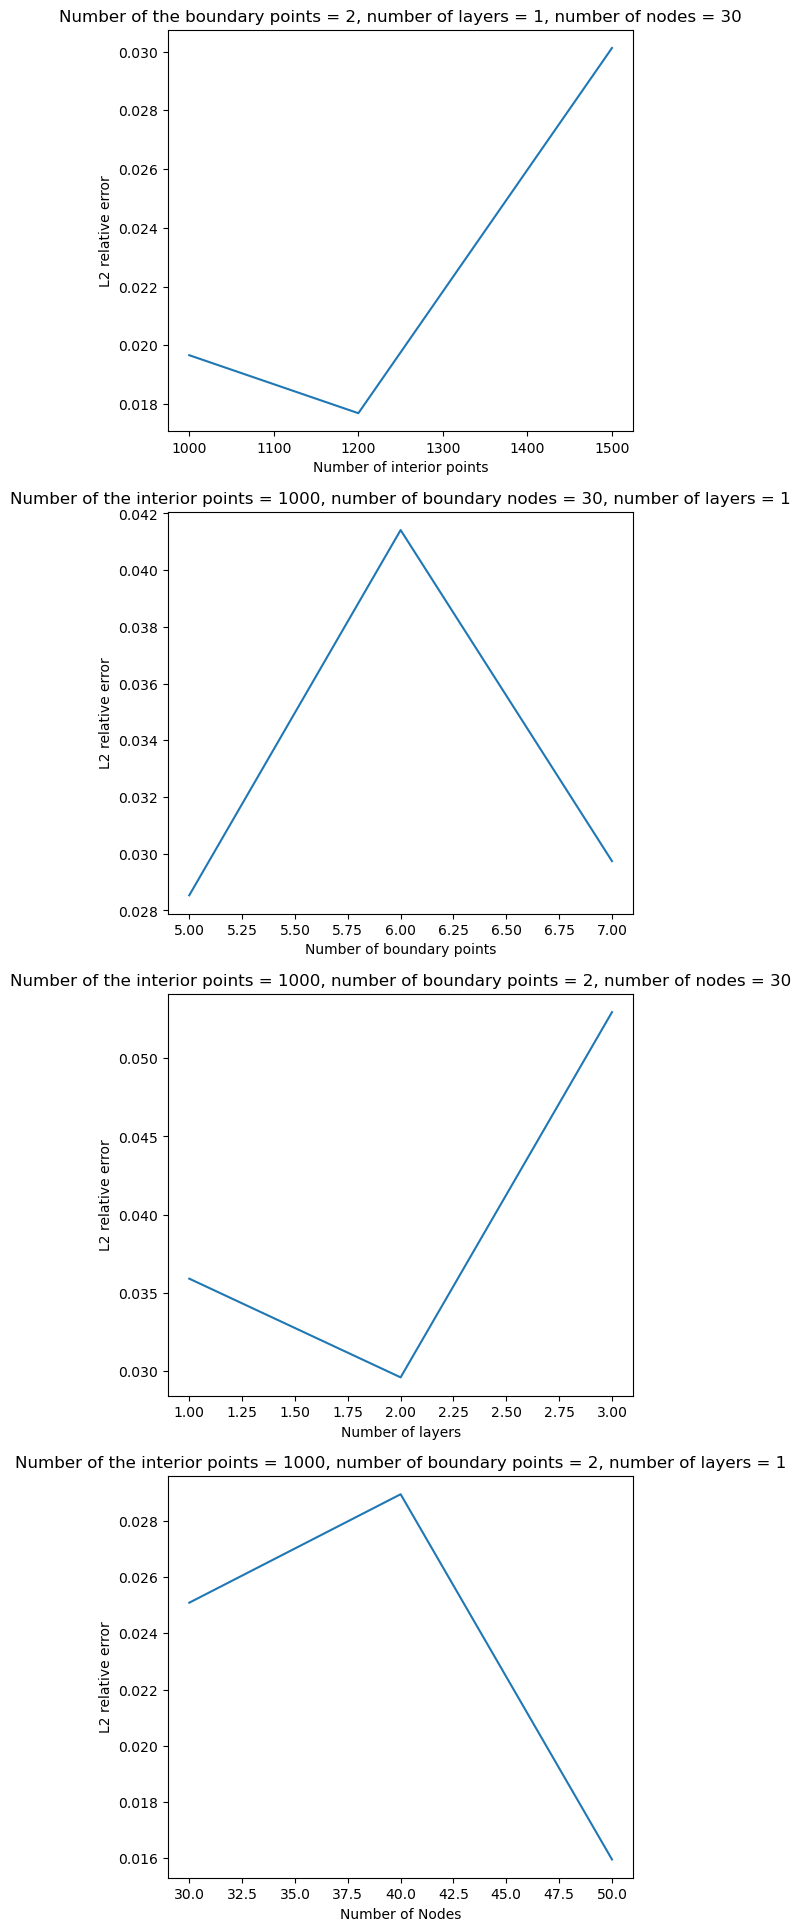

In [26]:
plt.figure(figsize= (6,24))
#plt.suptitle('L2 errors relative to the exact solution for omegra = 2, based on model architecture')

plt.subplot(4,1,1)
plt.plot(num_i,acc_i)
plt.xlabel('Number of interior points')
plt.ylabel('L2 relative error')
plt.title('Number of the boundary points = 2, number of layers = 1, number of nodes = 30')

plt.subplot(4,1,2)
plt.plot(num_b,acc_b)
plt.xlabel('Number of boundary points')
plt.ylabel('L2 relative error')
plt.title('Number of the interior points = 1000, number of boundary nodes = 30, number of layers = 1')

plt.subplot(4,1,3)
plt.plot(num_l,acc_l)
plt.xlabel('Number of layers')
plt.ylabel('L2 relative error')
plt.title('Number of the interior points = 1000, number of boundary points = 2, number of nodes = 30')

plt.subplot(4,1,4)
plt.plot(num_n,acc_n)
plt.xlabel('Number of Nodes')
plt.ylabel('L2 relative error')
plt.title('Number of the interior points = 1000, number of boundary points = 2, number of layers = 1')

plt.show()

Therefore it is clear that the optimal accuracy is achieved for 5 boundary points, 1200 interior points, 2 layers, and 50 neurons in each layer.

## Problem 3:

### A system of linear PDEs

Consider the system \begin{array}{l}
v_t - a v_{xx} = -v ,\\
w_t - a w_{xx} =  v - 2 w.
\end{array}
with initial conditions
\begin{array}{l}
v(x,0) = x^2+1,\\
w(x,0) = 0,
\end{array}
and boundary conditions
\begin{array}{l}
v(0,t) = \left(2at+1\right)e^{-t}, \\
v(1,t) = \left(2at+2\right)e^{-t},\\
w(0,t) = \left(2at+1\right)\left(e^{-t}-e^{-2t}\right), \\
w(1,t) = \left(2at+2\right)\left(e^{-t}-e^{-2t}\right).
\end{array}
The exact solution of the system is
\begin{array}{l}
v(x,t)= \left(x^2 + 2at + 1\right)e^{- t},\\
w(x,t)= \left(x^2 + 2at + 1\right)\left(e^{- t}-  e^{-2t}\right).
\end{array}

In [32]:
a = 2
x_max = 1
t_max = 1

def v_sol(X, T):
    return (X**2 + 2*a*T + 1)*np.exp(-T)
def w_sol(X, T):
    return (X**2 + 2*a*T + 1)*(np.exp(-T) - np.exp(-2*T))
def sys_sol(Z):
    v = v_sol(Z[:,:1], Z[:,1:])
    w = w_sol(Z[:,:1], Z[:,1:])
    return np.stack([v.flatten(), w.flatten()], 1)

x = np.linspace(0,1,100)
t = np.linspace(0,1,100)

X, T = np.meshgrid(x, t)

In [34]:
geom = dde.geometry.Rectangle((0,0), (1, 1))

x_begin = 0; x_end = 1
def boundary_bottom(z,on_boundary):  
    return dde.utils.isclose(z[1],x_begin)

def boundary_top(z,on_boundary):  
    return dde.utils.isclose(z[1],x_end)

def ic_begin(z,on_boundary):
    return dde.utils.isclose(z[0],0)


bc_bottom_v = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 1)*tf.exp(-z[:,0:1])], boundary_bottom, component = 0)
bc_bottom_w = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 1)*(tf.exp(-z[:,0:1])-tf.exp(-2*z[:,0:1]))],boundary_bottom, component = 1)

bc_top_v    = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 2)*tf.exp(-z[:,0:1])],boundary_top, component = 0)
bc_top_w    = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 2)*(tf.exp(-z[:,0:1])-tf.exp(-2*z[:,0:1]))],boundary_top, component = 1)

bcs = [bc_top_v, bc_top_w, bc_bottom_v, bc_bottom_w]


def HEAT2_deepxde(z,y):
    
    v = y[:,0:1]
    w = y[:,1:2]
    
    dw_dt = dde.grad.jacobian(w,z,0,0)
    dw_dx = dde.grad.jacobian(w,z,0,1)
    d2w_dx2 = dde.grad.jacobian(dw_dx,z,0,1)
    
    dv_dt = dde.grad.jacobian(v,z,0,0)
    dv_dx = dde.grad.jacobian(v,z,0,1)
    d2v_dx2 = dde.grad.jacobian(dv_dx,z,0,1)
    
    return [
        dv_dt - a * d2v_dx2 + v,
        dw_dt - a * d2w_dx2 - v + 2*w
    ]

def output_transform(z, q): # Here we applied the initial conditions as 'Hard constraints'
    v = q[:, 0:1]
    w = q[:, 1:2]
    t = z[:, 0:1]
    x = z[:, 1:2]
    return tf.concat([v * tf.tanh(t) + x**2+1, w * tf.tanh(t)], axis=1)


data = dde.data.PDE(geom, HEAT2_deepxde,bcs,
                        solution = sys_sol,
                        num_domain = 1000,
                        num_boundary = 6,
                        num_test=100)
    
net = dde.nn.FNN([2] + [60]*4 + [2], 'tanh', 'He uniform')
net.apply_output_transform(output_transform)

model = dde.Model(data, net)
model.compile('adam', lr = 0.001, metrics = [])
losshistory, train_state = model.train(iterations = 2000, display_every = 1000)
    
Z_pred = model.predict(np.stack((T.ravel(), X.ravel()), axis=-1)).reshape(len(t), len(x),2)




Compiling model...
Building feed-forward neural network...
'build' took 0.137353 s

'compile' took 3.434075 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.75e+01, 2.23e+01, 9.58e-02, 3.98e+00, 6.18e-01, 5.24e-01]    [3.02e+01, 2.44e+01, 9.58e-02, 3.98e+00, 6.18e-01, 5.24e-01]    []  
1000      [1.36e-03, 9.96e-04, 2.09e-04, 3.66e-04, 1.77e-05, 6.73e-05]    [7.25e-04, 6.33e-04, 2.09e-04, 3.66e-04, 1.77e-05, 6.73e-05]    []  
2000      [3.38e-04, 3.75e-04, 1.79e-05, 1.08e-05, 2.21e-06, 4.39e-06]    [2.08e-04, 2.45e-04, 1.79e-05, 1.08e-05, 2.21e-06, 4.39e-06]    []  

Best model at step 2000:
  train loss: 7.48e-04
  test loss: 4.88e-04
  test metric: []

'train' took 62.812171 s



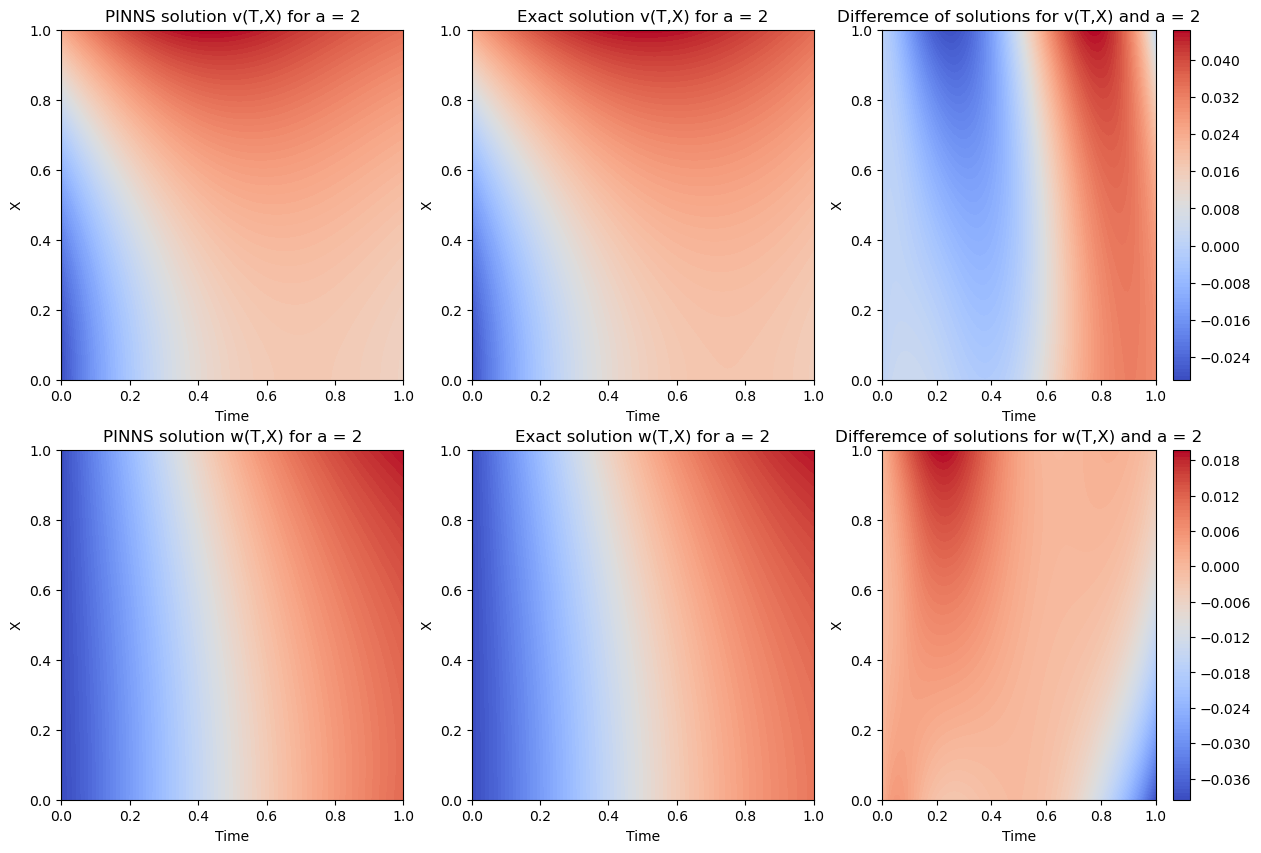

In [35]:
plt.figure(figsize=(15, 10))
    
plt.subplot(2,3,1)
plt.contourf(T, X, Z_pred[:,:,0], cmap="coolwarm", levels=100)
plt.xlabel('Time')
plt.ylabel('X')
plt.title('PINNS solution v(T,X) for a = {}'.format(a))  

plt.subplot(2,3,2)
plt.contourf(T, X, v_sol(X,T), cmap="coolwarm", levels=100)
plt.xlabel('Time')
plt.ylabel('X')
plt.title('Exact solution v(T,X) for a = {}'.format(a)) 

plt.subplot(2,3,3)
plt.contourf(T, X, v_sol(X,T) - Z_pred[:,:,0], cmap="coolwarm", levels=100)
plt.xlabel('Time')
plt.ylabel('X')
plt.title('Differemce of solutions for v(T,X) and a = {}'.format(a))
plt.colorbar()



plt.subplot(2,3,4)
plt.contourf(T, X, Z_pred[:,:,1], cmap="coolwarm", levels=100)
plt.xlabel('Time')
plt.ylabel('X')
plt.title('PINNS solution w(T,X) for a = {}'.format(a))  

plt.subplot(2,3,5)
plt.contourf(T, X, w_sol(X,T), cmap="coolwarm", levels=100)
plt.xlabel('Time')
plt.ylabel('X')
plt.title('Exact solution w(T,X) for a = {}'.format(a)) 

plt.subplot(2,3,6)
plt.contourf(T, X, w_sol(X,T) - Z_pred[:,:,1], cmap="coolwarm", levels=100)
plt.xlabel('Time')
plt.ylabel('X')
plt.title('Differemce of solutions for w(T,X) and a = {}'.format(a))
plt.colorbar()
    
plt.show()

Again the PINNS solution for both components (v,w) is very close to the actual solution. Specially the train/test loss is of order $10^{-4}$. We study the accuracy more precisely bellow:

In [36]:
# Model accuracy study: (similar to the previous question)


def acc_par(boundary_points, interior_points, layer, nodes):
    bound=boundary_points
    inter=interior_points
    
    
   
    
    data = dde.data.PDE(geom, HEAT2_deepxde,bcs, 
                        num_domain = inter,
                        num_boundary = bound,
                        num_test=50)
    
    
    net = dde.nn.FNN([2] + [nodes]*layer + [2], 'tanh', 'He uniform')
    net.apply_output_transform(output_transform)

    model = dde.Model(data, net)
    model.compile('adam', lr = 0.01, metrics = [])
    losshistory, train_state = model.train(iterations = 500, display_every = 500)
    
    
    Z_pred = model.predict(np.stack((T.ravel(), X.ravel()), axis=-1)).reshape(len(t), len(x),2)
    Z_true = np.stack([v_sol(X,T),w_sol(X,T)], -1)
    
    return dde.metrics.l2_relative_error(Z_true,Z_pred)


num_b = [5,6,7]  # Boundary points
num_i = [1000, 1200, 1500] # Interior points
num_l = [1,2,3]
num_n = [30,40,50]

acc_i = []
for ni in num_i:
    nb = 5; nl = 1; nn = 30
    acc_i.append(acc_par(nb,ni,nl,nn))
acc_l = []
for nl in num_l:
    ni = 1000; nb = 5; nn = 30
    acc_l.append(acc_par(nb,ni,nl,nn))
acc_n = []
for nn in num_n:
    ni = 1000; nb = 5; nl = 1
    acc_n.append(acc_par(nb,ni,nl,nn))
acc_b = []
for nb in num_b:
    ni = 1000; nl = 1; nn = 30 
    acc_b.append(acc_par(nb,ni,nl,nn))

    


Compiling model...
Building feed-forward neural network...
'build' took 0.077397 s

'compile' took 2.204543 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [7.96e+00, 8.59e-01, 6.59e-01, 4.05e-01, 9.40e-01, 2.80e-01]    [7.99e+00, 7.22e-01, 6.59e-01, 4.05e-01, 9.40e-01, 2.80e-01]    []  
500       [1.84e-02, 2.27e-03, 5.76e-03, 1.23e-03, 4.10e-04, 1.86e-04]    [1.36e-02, 1.10e-03, 5.76e-03, 1.23e-03, 4.10e-04, 1.86e-04]    []  

Best model at step 500:
  train loss: 2.83e-02
  test loss: 2.23e-02
  test metric: []

'train' took 6.057991 s

Compiling model...
Building feed-forward neural network...
'build' took 0.031867 s

'compile' took 2.791767 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.46e+01, 4.96e+00, 3.79e-01,

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [5.90e+00, 1.46e+00, 2.44e-01, 8.01e-01, 1.23e-01, 2.80e-01]    [5.43e+00, 1.05e+00, 2.44e-01, 8.01e-01, 1.23e-01, 2.80e-01]    []  
500       [5.89e-03, 3.17e-03, 1.66e-03, 1.20e-03, 1.82e-04, 8.07e-05]    [4.01e-03, 1.77e-03, 1.66e-03, 1.20e-03, 1.82e-04, 8.07e-05]    []  

Best model at step 500:
  train loss: 1.22e-02
  test loss: 8.90e-03
  test metric: []

'train' took 7.727768 s



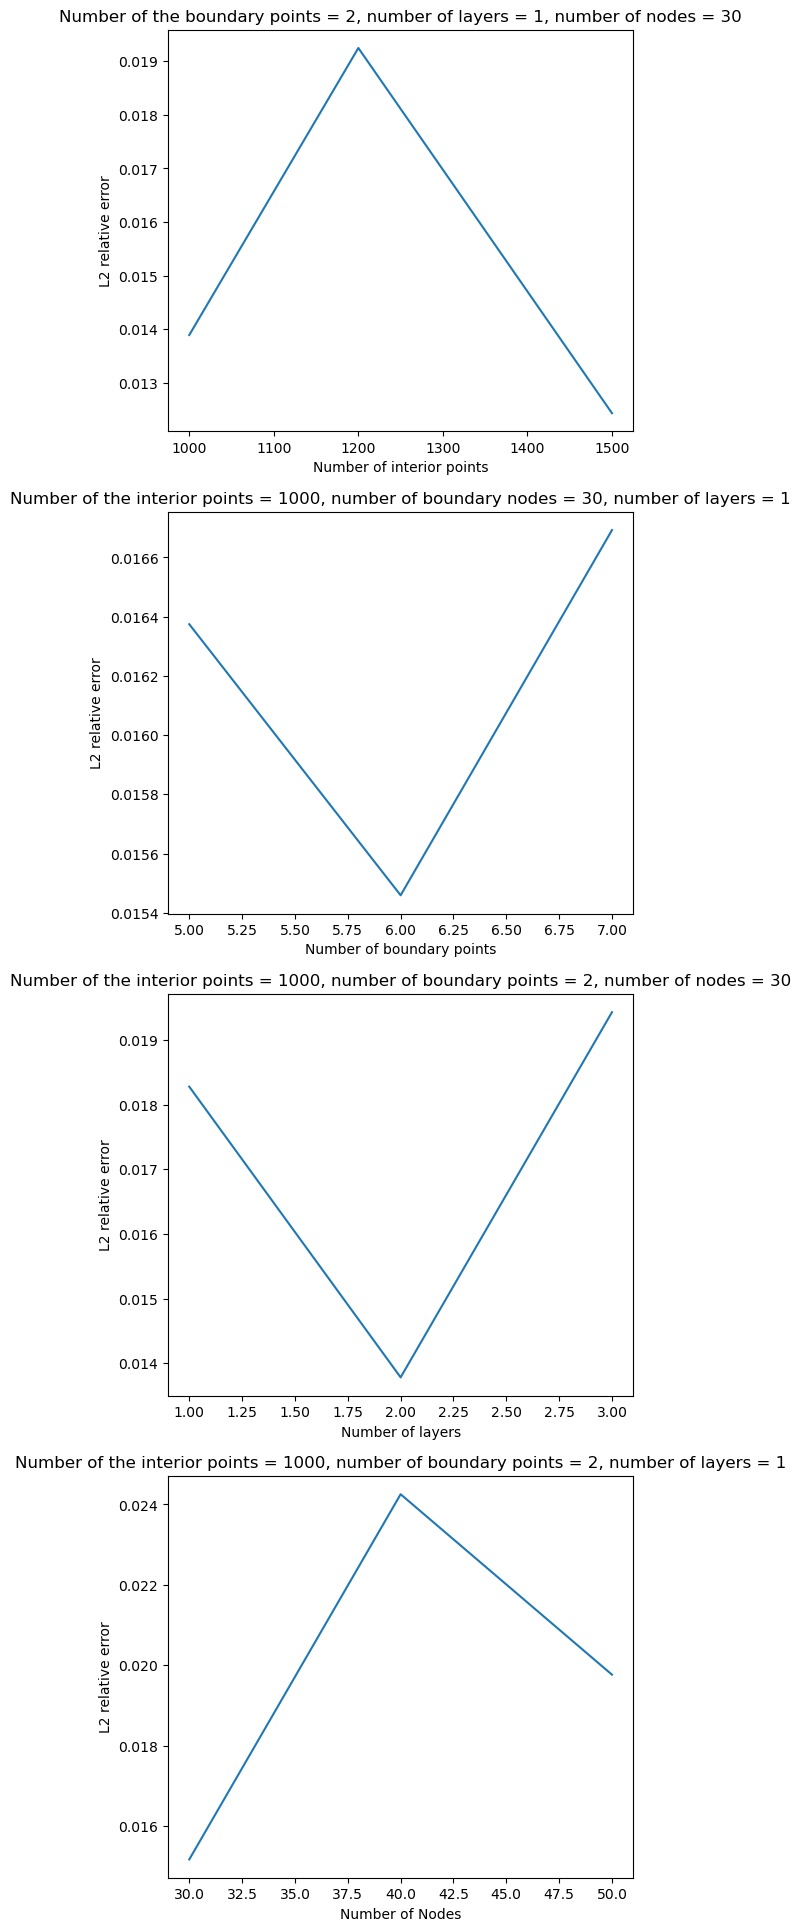

In [37]:
plt.figure(figsize= (6,24))
#plt.suptitle('L2 errors relative to the exact solution for omegra = 2, based on model architecture')

plt.subplot(4,1,1)
plt.plot(num_i,acc_i)
plt.xlabel('Number of interior points')
plt.ylabel('L2 relative error')
plt.title('Number of the boundary points = 2, number of layers = 1, number of nodes = 30')

plt.subplot(4,1,2)
plt.plot(num_b,acc_b)
plt.xlabel('Number of boundary points')
plt.ylabel('L2 relative error')
plt.title('Number of the interior points = 1000, number of boundary nodes = 30, number of layers = 1')

plt.subplot(4,1,3)
plt.plot(num_l,acc_l)
plt.xlabel('Number of layers')
plt.ylabel('L2 relative error')
plt.title('Number of the interior points = 1000, number of boundary points = 2, number of nodes = 30')

plt.subplot(4,1,4)
plt.plot(num_n,acc_n)
plt.xlabel('Number of Nodes')
plt.ylabel('L2 relative error')
plt.title('Number of the interior points = 1000, number of boundary points = 2, number of layers = 1')

plt.show()

The optimum l2-accuracy is achieved for 1500 interior points, 6 boundary points, 2 layers, and 30 nodes in each layer. 

## Problem 4:

### Helmholtz equation

Consider the Dirichlet problem $$\nabla^2 E(x,y) + \frac{\pi^2}{2}E(x,y) = 0,\qquad x,y \in \Omega =[-2, 2]^2,$$
subject to boundary conditions
$$E(-2,y)=E(2,y)=-\cos\left(\frac{\pi}{2} y\right)-\sin\left(\frac{\pi}{2} y\right),$$
$$E(x,-2)=E(x, 2)=-\cos\left(\frac{\pi}{2} x\right)-\sin\left(\frac{\pi}{2} x\right).$$

We want to find the following solution using a neural network $$ E^*(x,y) = \cos\frac{\pi\left(x- y\right)}{2}+ \sin\frac{\pi\left(x + y\right)}{2}.$$
There are many other solutions to the Dirichlet problem above, for example $(x,y)\mapsto \sin\left(\frac{\pi}{2} x\right)\sin\left(\frac{\pi}{2} y\right)$ is a solution. So to learn $E^*$ we need to provide the neural network with additional training points. We'll provide you with a function that generates training points from the true solution.

In [32]:
def helm_sol(X, Y):
    return np.cos((X-Y)*np.pi/2)+np.sin((X+Y)*np.pi/2)

x_min = -2; x_max = 2
y_min = -2; y_max = 2
x = np.linspace(x_min, x_max, 100)
y = np.linspace(y_min, y_max, 100)
X, Y = np.meshgrid(x, y)

def helm_data(num_pts=10):
    X = np.random.uniform(x_min, x_max, num_pts)
    Y = np.random.uniform(y_min, y_max, num_pts)
    Z = np.stack([X, Y], 1)
    return Z, helm_sol(X, Y).reshape(num_pts, 1)

# PINNS Solutions

def exact_solution(z):
    x = z[:,0:1]
    y = z[:,1:2]
    
    E = np.cos((x-y)*np.pi/2) + np.sin((x+y)*np.pi/2)
    
    return E


geom = dde.geometry.Rectangle((x_min,y_min), (x_max,y_max))

def boundary_xmin(z,on_boundary):  
    return dde.utils.isclose(z[0],x_min)

def boundary_xmax(z,on_boundary):  
    return dde.utils.isclose(z[0],x_max)

def boundary_ymin(z,on_boundary):  
    return dde.utils.isclose(z[1],y_min)

def boundary_ymax(z,on_boundary):  
    return dde.utils.isclose(z[1],y_max)

bc_min_x = dde.icbc.DirichletBC (geom, lambda z: -tf.cos(z[:,1:2]*np.pi/2) - tf.sin(z[:,1:2]*np.pi/2), boundary_xmin, component = 0)
bc_max_x = dde.icbc.DirichletBC (geom, lambda z: -tf.cos(z[:,1:2]*np.pi/2) - tf.sin(z[:,1:2]*np.pi/2), boundary_xmax, component = 0)

bc_min_y = dde.icbc.DirichletBC (geom, lambda z:  -tf.cos(z[:,0:1]*np.pi/2) - tf.sin(z[:,0:1]*np.pi/2), boundary_ymin, component = 0)
bc_max_y = dde.icbc.DirichletBC (geom, lambda z:  -tf.cos(z[:,0:1]*np.pi/2) - tf.sin(z[:,0:1]*np.pi/2), boundary_ymax, component = 0)

points, Es = helm_data(num_pts = 10)
observe = dde.icbc.PointSetBC(points, Es )

bcs = [bc_min_x, bc_max_x,bc_min_y, bc_max_y, observe]

def Helmholtz_deepxde(z,h):
    
    E = h[:, 0:1]
    
    dE_dx = dde.grad.jacobian(E,z,0,0)
    d2E_dx2 = dde.grad.jacobian(dE_dx,z,0,0)
    dE_dy = dde.grad.jacobian(E,z,0,1)
    d2E_dy2 = dde.grad.jacobian(dE_dy,z,0,1)
    
    
    return d2E_dx2 + d2E_dy2 + (2*(np.pi/2)**2) * E

data = dde.data.PDE(geom, Helmholtz_deepxde,bcs, 
                        num_domain = 1000,
                        solution = exact_solution,
                        num_boundary = 100,
                        num_test = 50,
                    anchors = points
                       )

net = dde.nn.FNN([2] + [60]*7 + [1], 'sin', 'Glorot normal')
model = dde.Model(data, net)
model.compile('adam', lr = 0.01, metrics = [])
losshistory, train_state = model.train(iterations = 1000, display_every = 1000)
    
Z_pred = model.predict(np.stack((X.ravel(), Y.ravel()), axis=-1)).reshape(len(x), len(y), 1)


Compiling model...
Building feed-forward neural network...
'build' took 0.253426 s

'compile' took 8.642947 s

Training model...

0         [1.30e+00, 1.28e+00, 1.22e+00, 8.90e-01, 8.14e-01, 1.55e+00]    [1.12e+00, 1.28e+00, 1.22e+00, 8.90e-01, 8.14e-01, 1.55e+00]    []  
1000      [6.67e-03, 8.82e-04, 6.24e-04, 1.03e-03, 4.03e-04, 4.26e-04]    [6.34e-03, 8.82e-04, 6.24e-04, 1.03e-03, 4.03e-04, 4.26e-04]    []  

Best model at step 1000:
  train loss: 1.00e-02
  test loss: 9.70e-03
  test metric: []

'train' took 92.092183 s



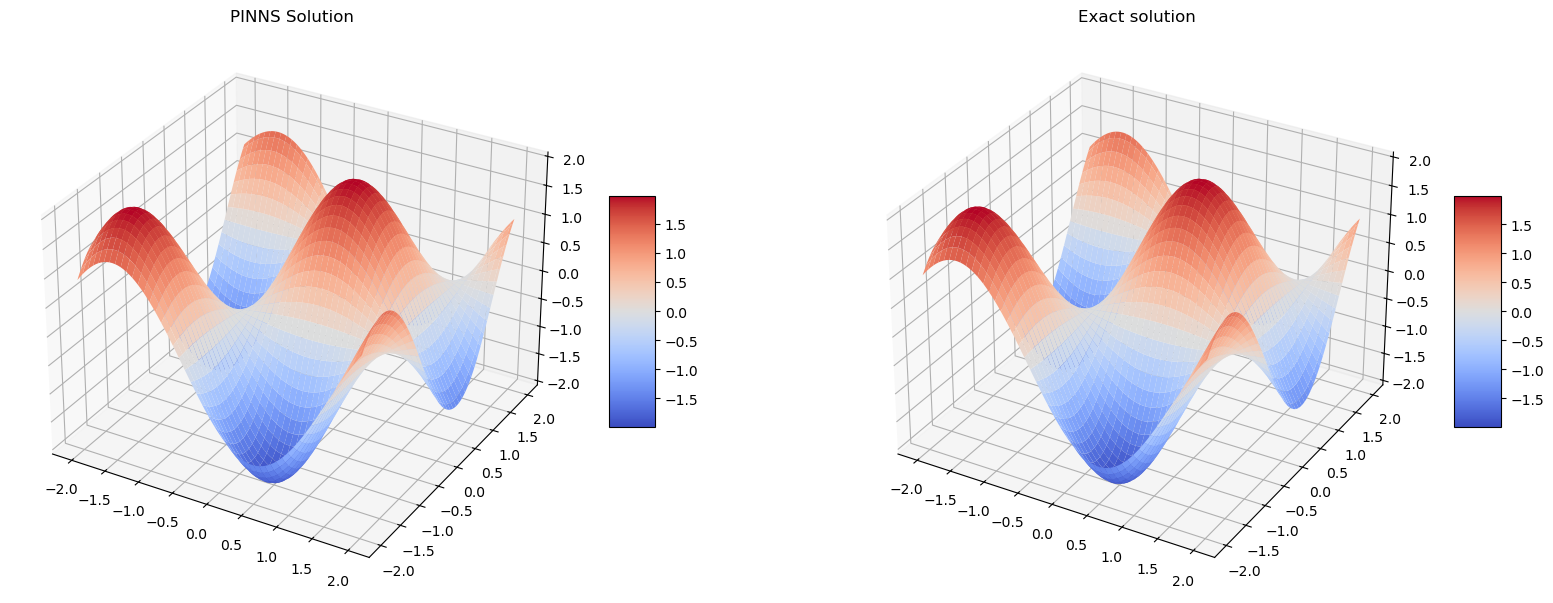

In [34]:
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z = helm_sol(X,Y)


fig, ax = plt.subplots(1,2 , subplot_kw={"projection": "3d"}, figsize = (20,10))

surf_PINNS = ax[0].plot_surface(X, Y, Z_pred[:,:,0], cmap="coolwarm")
fig.colorbar(surf_PINNS, shrink=0.3, aspect=5)
ax[0].set_title('PINNS Solution')

surf_EXACT = ax[1].plot_surface(X, Y, Z, cmap='coolwarm')
fig.colorbar(surf_EXACT, shrink=0.3, aspect=5)
ax[1].set_title('Exact solution')

plt.show()

## Problem 5:

### Hamilton-Jacobi equation

Consider the Hamilton-Jacobi equation \begin{array}{l}\varphi_t+\sin(x)\varphi_x = 0, \;  x\in[0, 2\pi], \; t\in[0, 1], \\ \varphi(x, 0) = \sin(x), \\ \varphi(0, t) = \varphi(2\pi, t)= 0.  \end{array}

The exact solution is
$$
\varphi(x,t) = \sin\left(2\arctan\left(e^{-t}\tan\left(\frac{x}{2} \right)\right)\right)
$$

In [20]:
# PINNS Solution:

t_max = 1; t_min = 0
x_max = 2*np.pi; x_min = 0
x = np.linspace(x_min, x_max, 100)
t = np.linspace(t_min, t_max, 100)
X, T = np.meshgrid(x, t)


geom = dde.geometry.Rectangle((x_min,t_min), (x_max,t_max))

def boundary_bottom(z,on_boundary):  
    return dde.utils.isclose(z[0],x_min)

def boundary_top(z,on_boundary):  
    return dde.utils.isclose(z[0],x_max)


bc_min_x = dde.icbc.DirichletBC (geom, lambda z: 0, boundary_bottom, component = 0)
bc_max_x = dde.icbc.DirichletBC (geom, lambda z: 0, boundary_top,    component = 0)
bcs = [bc_min_x, bc_max_x]

def HJ_deepxde(z,y):
    
    phi = y[:, 0:1]
    x = z[:, 0:1]
    t = z[:, 1:2]
    
    dphi_dt = dde.grad.jacobian(phi,z,0,1)
    dphi_dx = dde.grad.jacobian(phi,z,0,0)
    
    
    return dphi_dt  + tf.sin(x) * dphi_dx

def output_transform(z, q): # Here we applied the initial conditions as 'Hard constraints'
    phi = q[:, 0:1]
    
    x = z[:, 0:1]
    t = z[:, 1:2]
    
    return phi * tf.tanh(t) + tf.sin(x)

data = dde.data.PDE(geom, HJ_deepxde,bcs, 
                        num_domain = 1000,
                        num_boundary = 15,
                        num_test = 100
                       )
                       
net = dde.nn.FNN([2] + [30]*4 + [1], 'tanh', 'He normal')
net.apply_output_transform(output_transform)

model = dde.Model(data, net)
model.compile('adam', lr = 0.005, metrics = [])
losshistory, train_state = model.train(iterations = 2000, display_every = 2000)
    
Z_pred = model.predict(np.stack((X.ravel(), T.ravel()), axis=-1)).reshape(len(x), len(t), 1)

Compiling model...
Building feed-forward neural network...
'build' took 0.174807 s

'compile' took 0.596145 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.10e-01, 8.82e-03, 7.36e-02]    [3.34e-01, 8.82e-03, 7.36e-02]    []  
2000      [9.44e-05, 2.97e-05, 5.48e-05]    [8.15e-05, 2.97e-05, 5.48e-05]    []  

Best model at step 2000:
  train loss: 1.79e-04
  test loss: 1.66e-04
  test metric: []

'train' took 7.093329 s



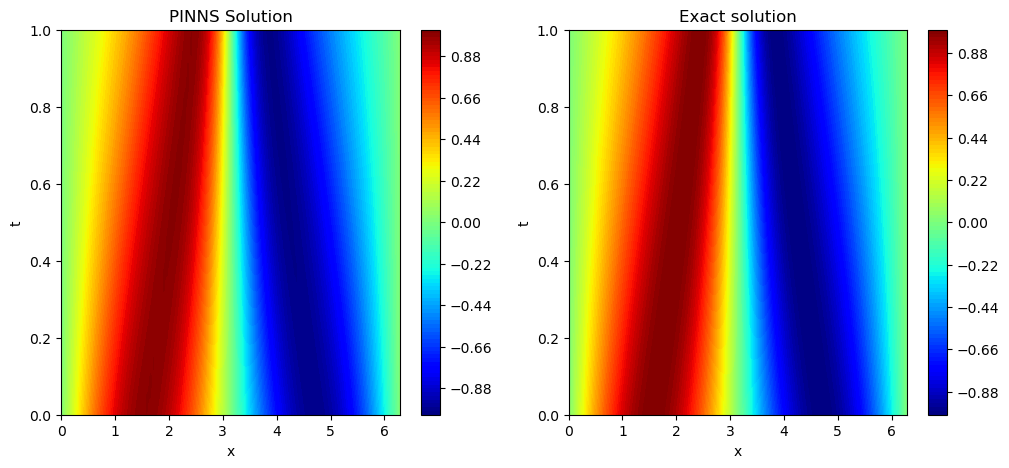

In [22]:
x = np.linspace(x_min, x_max, 100)
t = np.linspace(t_min, t_max, 100)
X, T = np.meshgrid(x, t)

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.contourf(X, T, Z_pred[:,:,0], cmap="jet", levels=100)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("PINNS Solution")

plt.subplot(122)
plt.contourf(X, T, np.sin(2*np.arctan(np.exp(-T)*np.tan(X/2))), cmap="jet", levels=100)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("Exact solution")

plt.show()

It seems PINNS solution is very close to the exact solution. 

Let us see how the l2-error changes as we vary some of the NN and training parameters, as before: 

In [16]:
# Model accuracy study: (similar to the previous question)

x = np.linspace(x_min, x_max, 100)
t = np.linspace(t_min, t_max, 100)
X, T = np.meshgrid(x, t)

def phi_exact(z):
    t = z[:,0:1]
    x = z[:,1:2]
    return np.sin(2*np.arctan(np.exp(-t)*np.tan(x/2)))

def acc_par(boundary_points, interior_points, layer, nodes):
    bound=boundary_points
    inter=interior_points
    
    
    data = dde.data.PDE(geom, HJ_deepxde,bcs, 
                        num_domain = inter,
                        num_boundary = bound,
                        num_test=50)
    
    
    net = dde.nn.FNN([2] + [nodes]*layer + [1], 'tanh', 'He uniform')
    net.apply_output_transform(output_transform)

    model = dde.Model(data, net)
    model.compile('adam', lr = 0.01, metrics = [])
    losshistory, train_state = model.train(iterations = 500, display_every = 500)
    
    
    Z_pred = model.predict(np.stack((T.ravel(), X.ravel()), axis=-1)).reshape(len(t), len(x),1)
    Z_true = phi_exact(np.stack((T.ravel(), X.ravel()), axis = -1)).reshape(len(t), len(x),1)
    
    return dde.metrics.l2_relative_error(Z_true,Z_pred)


num_b = [30,40,50]  # Boundary points
num_i = [1000, 2000, 3000] # Interior points
num_l = [1,2,3]
num_n = [30,40,50]

acc_i = []
for ni in num_i:
    nb = 30; nl = 1; nn = 30
    acc_i.append(acc_par(nb,ni,nl,nn))
acc_l = []
for nl in num_l:
    ni = 1000; nb = 30; nn = 30
    acc_l.append(acc_par(nb,ni,nl,nn))
acc_n = []
for nn in num_n:
    ni = 1000; nb = 30; nl = 1
    acc_n.append(acc_par(nb,ni,nl,nn))
acc_b = []
for nb in num_b:
    ni = 1000; nl = 1; nn = 30 
    acc_b.append(acc_par(nb,ni,nl,nn))

    


Compiling model...
Building feed-forward neural network...
'build' took 0.048757 s

'compile' took 0.672317 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [6.31e-01, 1.64e-01, 1.11e-01]    [7.28e-01, 1.64e-01, 1.11e-01]    []  
500       [6.78e-02, 5.82e-07, 1.66e-03]    [7.07e-02, 5.82e-07, 1.66e-03]    []  

Best model at step 500:
  train loss: 6.95e-02
  test loss: 7.24e-02
  test metric: []

'train' took 1.309926 s

Compiling model...
Building feed-forward neural network...
'build' took 0.027146 s

'compile' took 0.402317 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [6.21e-01, 3.69e-02, 1.94e-01]    [6.83e-01, 3.69e-02, 1.94e-01]    []  
500       [7.61e-02, 8.04e-07, 1.65e-03]    [7.75e-02, 8.04e-07, 1.65e-03]    []  

Best model at step 500:
  train loss: 7.78e-02
  test loss: 7.92e-02
  test metric: []

'train' took 1.673647 s



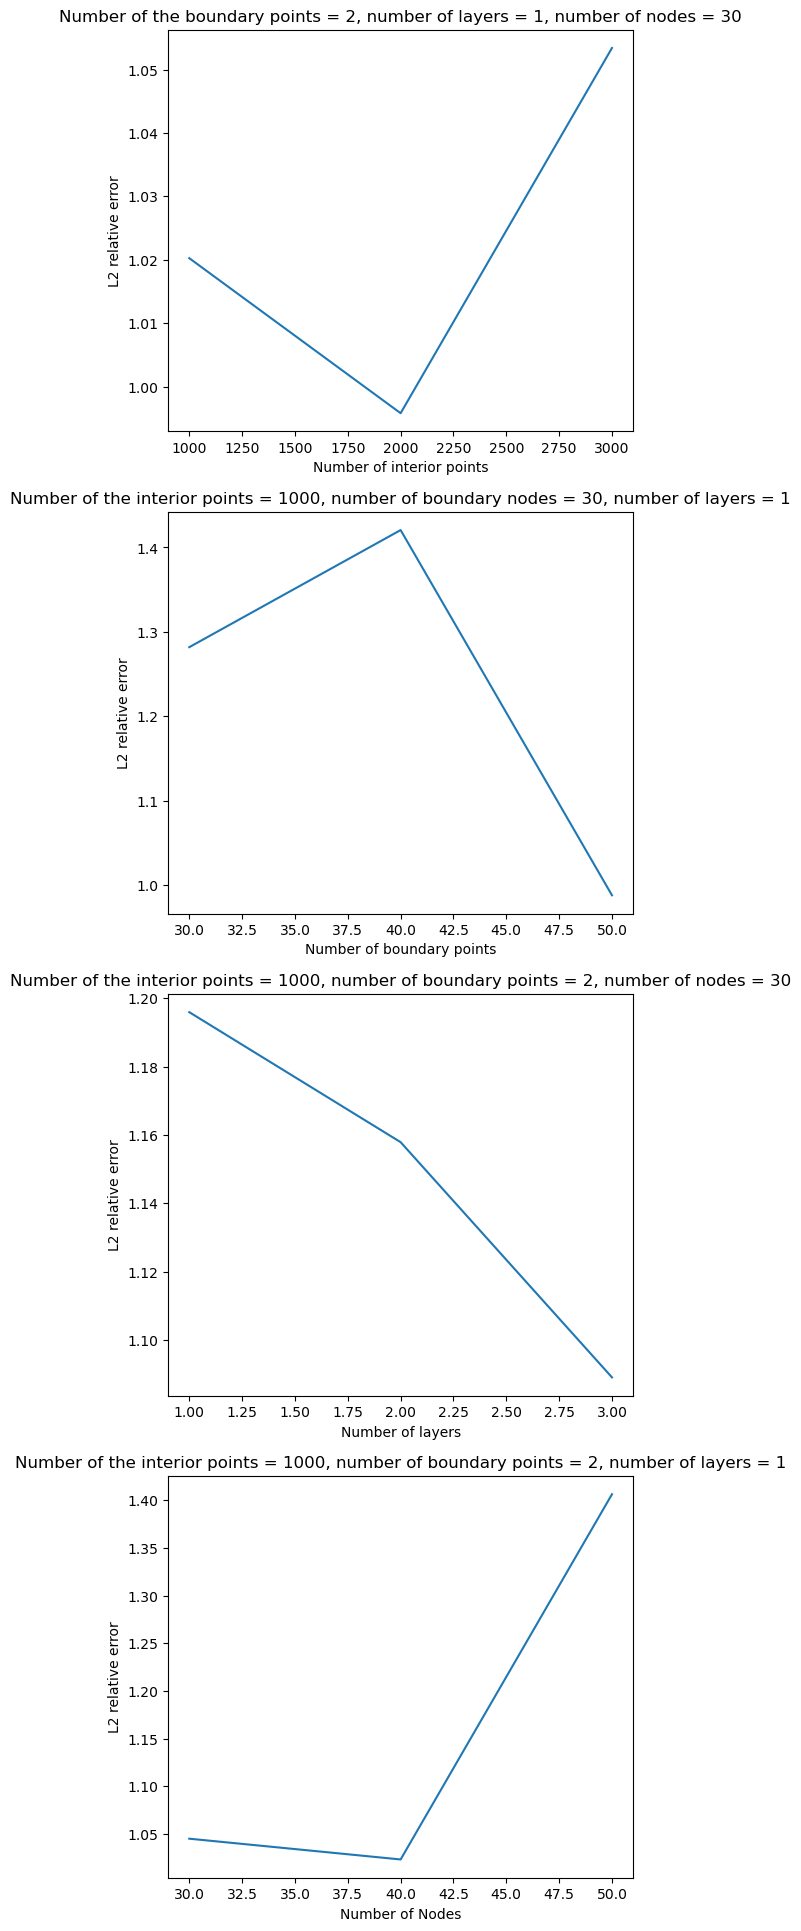

In [17]:
plt.figure(figsize= (6,24))
#plt.suptitle('L2 errors relative to the exact solution for omegra = 2, based on model architecture')

plt.subplot(4,1,1)
plt.plot(num_i,acc_i)
plt.xlabel('Number of interior points')
plt.ylabel('L2 relative error')
plt.title('Number of the boundary points = 2, number of layers = 1, number of nodes = 30')

plt.subplot(4,1,2)
plt.plot(num_b,acc_b)
plt.xlabel('Number of boundary points')
plt.ylabel('L2 relative error')
plt.title('Number of the interior points = 1000, number of boundary nodes = 30, number of layers = 1')

plt.subplot(4,1,3)
plt.plot(num_l,acc_l)
plt.xlabel('Number of layers')
plt.ylabel('L2 relative error')
plt.title('Number of the interior points = 1000, number of boundary points = 2, number of nodes = 30')

plt.subplot(4,1,4)
plt.plot(num_n,acc_n)
plt.xlabel('Number of Nodes')
plt.ylabel('L2 relative error')
plt.title('Number of the interior points = 1000, number of boundary points = 2, number of layers = 1')

plt.show()

So the optimum l2-error is achieved for 2000 interior points, 50 boundary points, 3 layers, and 40 neurons in each layer.

## Problem 6:

### Klein-Gordon equation

#### Case 1

Let $a \in \mathbb{R}$ and $b>0$. Give an approximation to the solution of the equation $$\left(\partial_t^2 - a^2 \nabla^2 + b\right)\psi(x,t)=0, \quad (x,t) \in [1, 5]\times [0,T], $$
with initial conditions $$ \psi(x,0) = a \cos\left(\frac{\pi}{2} x \right) \quad\text{and}\quad \psi_t(x,0)=b\mu\cos\left(\frac{\pi}{2}x\right),$$
and Dirichlet boundary conditions $$ \psi(1,t) = \psi(5,t) = 0,$$

where $$\mu = \sqrt{b +\frac{a^2 \pi^2}{4}}.$$

The exact solution is $$\psi(x,t) = \cos\left(\frac{\pi x}{2}\right) \left(a \cos\left(\mu t \right) + b\sin\left(\mu t\right)\right).$$



In [78]:
#PINNS Solution

a = 2
b = 3
mu = np.sqrt(b + a**2 * np.pi**2 / 4)
t_min = 0
t_max = 2
x_min = 1
x_max = 5


def exact_solution(z):
    x = z[:,0:1]
    t = z[:,1:2]
    
    psi = np.cos(x*np.pi/2)*(a*np.cos(mu*t)+b*np.sin(mu*t))
    
    return psi
    
x = np.linspace(x_min, x_max, 100)
t = np.linspace(t_min, t_max, 100)
X, T = np.meshgrid(x,t)

geom = dde.geometry.Rectangle((x_min,t_min), (x_max,t_max))

def boundary_bottom(z,on_boundary):  
    return dde.utils.isclose(z[0],x_min)

def boundary_top(z,on_boundary):  
    return dde.utils.isclose(z[0],x_max)

def ic_begin(z,on_boundary):
    return dde.utils.isclose(z[1],0)


bc_min_x = dde.icbc.DirichletBC (geom, lambda z: 0, boundary_bottom, component = 0)
bc_max_x = dde.icbc.DirichletBC (geom, lambda z: 0, boundary_top,    component = 0)

bc_t_min_N = dde.icbc.NeumannBC(geom,lambda z: -b*mu*tf.cos(((np.pi)/2)*z[:,0:1]),ic_begin,component=0)

bcs = [bc_min_x, bc_max_x, bc_t_min_N]

def KG_deepxde(z,y):
    
    psi = y[:, 0:1]
    
    dpsi_dt = dde.grad.jacobian(psi,z,0,1)
    d2psi_dt2 = dde.grad.jacobian(dpsi_dt,z,0,1)
    dpsi_dx = dde.grad.jacobian(psi,z,0,0)
    d2psi_dx2 = dde.grad.jacobian(dpsi_dx,z,0,0)
    
    
    return d2psi_dt2  - (a**2)* d2psi_dx2 + b*psi


def output_transform(z, q): # Here we applied the initial conditions as 'Hard constraints'
    psi = q[:, 0:1]
    
    x = z[:, 0:1]
    t = z[:, 1:2]
    
    return psi * tf.tanh(t) + a*tf.cos(((np.pi)/2)*x)


data = dde.data.PDE(geom, KG_deepxde,bcs, 
                        num_domain = 1500,
                        solution = exact_solution,
                        num_boundary = 30,
                        num_test = 100
                       )
    
net = dde.nn.FNN([2] + [60]*4 + [1], 'tanh', 'Glorot uniform')
net.apply_output_transform(output_transform)

model = dde.Model(data, net)
model.compile('adam', lr = 0.005, metrics = [])
losshistory, train_state = model.train(iterations = 2000, display_every = 2000)
    
Z_pred = model.predict(np.stack((X.ravel(), T.ravel()), axis=-1)).reshape(len(x), len(t), 1)

Compiling model...
Building feed-forward neural network...
'build' took 0.228425 s

'compile' took 4.025395 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.25e+02, 5.63e-02, 9.56e-03, 6.24e+01]    [3.48e+02, 5.63e-02, 9.56e-03, 6.24e+01]    []  
2000      [4.45e-01, 1.64e-03, 3.57e-02, 4.76e-02]    [4.06e-01, 1.64e-03, 3.57e-02, 4.76e-02]    []  

Best model at step 2000:
  train loss: 5.30e-01
  test loss: 4.91e-01
  test metric: []

'train' took 96.947859 s



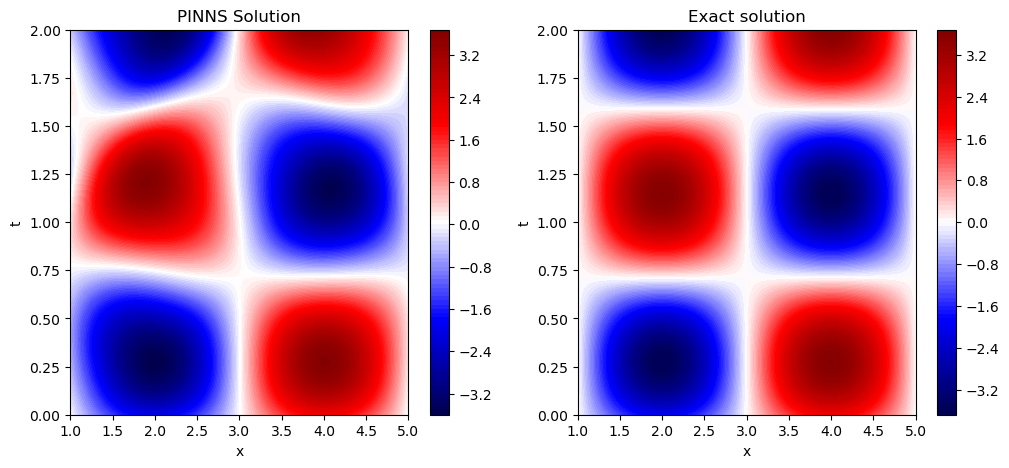

In [89]:
x = np.linspace(x_min, x_max, 100)
t = np.linspace(0, t_max, 100)
X, T = np.meshgrid(x, t)

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.contourf(X, T, Z_pred[:,:,0], cmap="seismic", levels=100)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("PINNS Solution")

plt.subplot(122)
plt.contourf(X, T, np.cos(X*np.pi/2)*(a*np.cos(mu*T)+b*np.sin(mu*T)), cmap="seismic", levels=100)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("Exact solution")

plt.show()

So it seems the PINNS solutions if pretty close to the actual solution.

#### Case 2

Let $a \in \mathbb{R}$ and $b>0$. Give an approximation to the solution of the equation $$\left(\partial_t^2 - a^2 \nabla^2 + b\right)\psi(x,t)=0, \quad (x,t) \in [0, 4]\times [0,T], $$

with initial conditions $$ \psi(x,0) = ae^{-\frac{\pi x}{2}} \quad \text{and}\quad \psi_t(x,0)=b\mu e^{-\frac{\pi}{2}x}$$
and boundary conditions
$$\psi(0, t) = a\cos(\mu t) + b\sin(\mu t)\qquad \text{and}\qquad
 \psi(4,t) = e^{-2\pi}\left(a\cos(\mu t) + b\sin(\mu t)\right)$$

where $$\mu = \sqrt{b -\frac{a^2 \pi^2}{4}}.$$

The exact solution is $$\psi(x,t)=e^{-\frac{\pi}{2} x}\left( a\cos(\mu t)+b\sin(\mu t)\right).$$

In [90]:
a = 1
b = 3
mu = np.sqrt(b - a**2 * np.pi**2 / 4)
t_min = 0; x_min = 0
t_max = 12
x_max = 4

x = np.linspace(x_min, x_max, 100)
t = np.linspace(t_min, t_max, 100)
X, T = np.meshgrid(x,t)


#PINNS Solution

def exact_solution(z):
    x = z[:,0:1]
    t = z[:,1:2]
    
    psi = np.exp(-(np.pi/2)*x)*(a*np.cos(mu*t)+b*np.sin(mu*t))
    
    return psi
    

geom = dde.geometry.Rectangle((x_min,t_min), (x_max,t_max))

def boundary_bottom(z,on_boundary):  
    return dde.utils.isclose(z[0],x_min)

def boundary_top(z,on_boundary):  
    return dde.utils.isclose(z[0],x_max)

def ic_begin(z,on_boundary):
    return dde.utils.isclose(z[1],0)


bc_min_x = dde.icbc.DirichletBC (geom, lambda z: a*tf.cos(mu*z[:,1:2])+b*tf.sin(mu*z[:,1:2]), boundary_bottom, component = 0)
bc_max_x = dde.icbc.DirichletBC (geom, lambda z: tf.exp(-2*np.pi)*(a*tf.cos(mu*z[:,1:2])+b*tf.sin(mu*z[:,1:2])), boundary_top,    component = 0)

bc_t_min_N = dde.icbc.NeumannBC(geom,lambda z: -b*mu*tf.exp(-(np.pi/2)*z[:,0:1]),ic_begin,component=0)

bcs = [bc_min_x, bc_max_x, bc_t_min_N]

def KG_deepxde(z,y):
    
    psi = y[:, 0:1]
    
    dpsi_dt = dde.grad.jacobian(psi,z,0,1)
    d2psi_dt2 = dde.grad.jacobian(dpsi_dt,z,0,1)
    dpsi_dx = dde.grad.jacobian(psi,z,0,0)
    d2psi_dx2 = dde.grad.jacobian(dpsi_dx,z,0,0)
    
    
    return d2psi_dt2  - (a**2)* d2psi_dx2 + b*psi


def output_transform(z, q): # Here we applied the initial conditions as 'Hard constraints'
    psi = q[:, 0:1]
    
    x = z[:, 0:1]
    t = z[:, 1:2]
    
    return psi * tf.tanh(t) + a*tf.exp(-(np.pi/2)*x)


data = dde.data.PDE(geom, KG_deepxde,bcs, 
                        num_domain = 1500,
                        solution = exact_solution,
                        num_boundary = 30,
                        num_test = 100
                       )
    
net = dde.nn.FNN([2] + [60]*4 + [1], 'tanh', 'Glorot uniform')
net.apply_output_transform(output_transform)

model = dde.Model(data, net)
model.compile('adam', lr = 0.005, metrics = [])
losshistory, train_state = model.train(iterations = 2000, display_every = 2000)
    
Z_pred = model.predict(np.stack((X.ravel(), T.ravel()), axis=-1)).reshape(len(x), len(t), 1)


Compiling model...
Building feed-forward neural network...
'build' took 1.233928 s

'compile' took 25.927620 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.68e-01, 5.44e+00, 1.38e-01, 7.73e-01]    [3.46e-01, 5.44e+00, 1.38e-01, 7.73e-01]    []  
2000      [9.21e-04, 3.83e-04, 6.15e-06, 1.70e-06]    [9.07e-04, 3.83e-04, 6.15e-06, 1.70e-06]    []  

Best model at step 2000:
  train loss: 1.31e-03
  test loss: 1.30e-03
  test metric: []

'train' took 119.767562 s



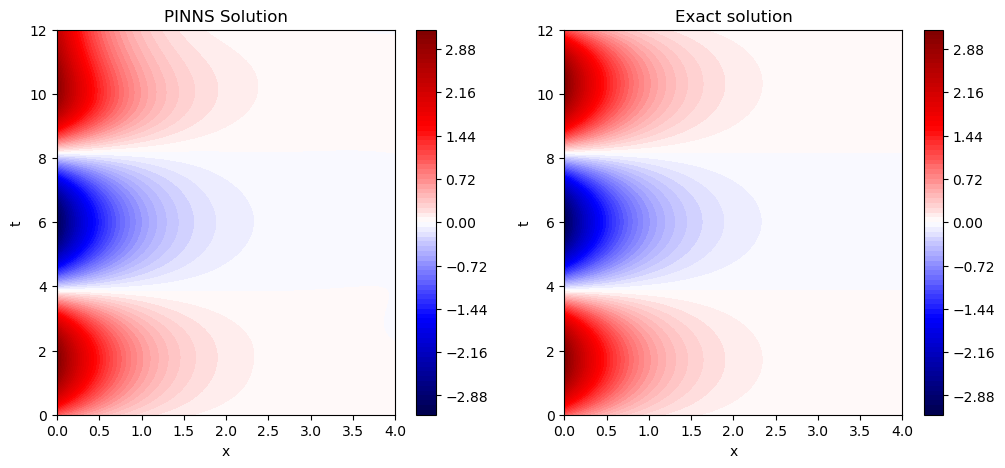

In [92]:
x = np.linspace(x_min, x_max, 100)
t = np.linspace(0, t_max, 100)
X, T = np.meshgrid(x, t)

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.contourf(X, T, Z_pred[:,:,0], cmap="seismic", levels=100)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("PINNS Solution")

plt.subplot(122)
plt.contourf(X, T, np.exp(-(np.pi/2)*X)*(a*np.cos(mu*T)+b*np.sin(mu*T)), cmap="seismic", levels=100)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("Exact solution")

plt.show()

Again PINNS returns a very good approxiamte in this case.

# Part 2 : Parameter Identification

## Problem 1: A simple ODE

$$\frac{dy}{dx} =\cos(\omega x), \quad x\in [-\pi , \pi],$$
with $y(0)=0$.

The exact solution is $y(x)=\frac{1}{\omega}\sin(\omega x)$.

* Use the following function to generate data points and learn the paramater $\omega^*=2$.

In [8]:
omega_star = 2.
x_max = 2*np.pi

def gen_data(num_pts=10, omega_star = omega_star):
    x = np.random.uniform(0, x_max, [num_pts, 1])
    return x, np.sin(omega_star*x)/omega_star


In [112]:
a = tf.Variable(1.)
#a = a.assign(2)
a

<tf.Variable 'Variable_8:0' shape=() dtype=float32_ref>

In [10]:


x = np.linspace(-np.pi, np.pi, 1000)
geom = dde.geometry.TimeDomain(x[0], x[-1])

x_begin = 0; y_begin = 0
def boundary_begin(x,_):  
    return dde.utils.isclose(x[0],x_begin)

def bc_func_begin(x,y,_): 
    
    return y - y_begin

bc1 = dde.icbc.OperatorBC(geom,bc_func_begin,boundary_begin)

def Simple_ODE(omega, omega_star):
    
    points, ys = gen_data(omega_star = omega_star)
    observe = dde.icbc.PointSetBC(points, ys )
    bcs = [bc1, observe]

    def ODE_deepxde(x,y):
        dy_dx = dde.grad.jacobian(y,x)
    
        return dy_dx - tf.cos(omega*x)
                
    data = dde.data.PDE(geom, ODE_deepxde,bcs, 
                        num_domain = 1000,
                        num_boundary = 2, 
                        num_test = 100,
                   anchors = points)

    net = dde.nn.FNN([1] + [60]*4 + [1], 'tanh', 'He uniform')
    model = dde.Model(data, net)
    
    parameters = dde.callbacks.VariableValue([omega], period=500)
    
    
    model.compile('adam', lr = 0.001, metrics = [])
    losshistory, train_state = model.train(iterations = 3000, callbacks=[parameters])
    
    return parameters.value

Simple_ODE(omega = tf.Variable(1.), omega_star = 2.)

Compiling model...
Building feed-forward neural network...
'build' took 0.140249 s

'compile' took 0.557344 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.86e+00, 0.00e+00, 3.39e+00]    [5.01e+00, 0.00e+00, 3.39e+00]    []  
0 [1.00e+00]
500 [7.46e-01]
1000      [7.48e-02, 3.46e-03, 3.65e-02]    [5.68e-02, 3.46e-03, 3.65e-02]    []  
1000 [9.98e-01]
1500 [1.49e+00]
2000      [2.02e-03, 4.31e-05, 4.26e-03]    [1.25e-03, 4.31e-05, 4.26e-03]    []  
2000 [1.79e+00]
2500 [1.94e+00]
3000      [6.04e-04, 1.17e-07, 1.25e-04]    [4.84e-05, 1.17e-07, 1.25e-04]    []  
3000 [1.97e+00]

Best model at step 3000:
  train loss: 7.30e-04
  test loss: 1.74e-04
  test metric: []

'train' took 20.560759 s



[1.9683194]

In [128]:
float(tf.Variable(1.))


TypeError: float() argument must be a string or a real number, not 'RefVariable'

The optimal value for $\omega = 1.99$ with the starting value $\omega_0 = 1$

In [31]:
omegas = [1., 3., 4., 5.]
omega_stars = [2., 3., 4., 5.]

optimum_o = []
for o in omegas:
    
    opt = Simple_ODE(omega = tf.Variable(o), omega_star = 2.)[0]
    optimum_o.append(opt)
    
optimum_os = []
for os in omega_stars:
    
    opt = Simple_ODE(omega = tf.Variable(2.5), omega_star = os)[0]
    optimum_os.append(opt)
    


Compiling model...
Building feed-forward neural network...
'build' took 0.076139 s

'compile' took 1.128883 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.45e-01, 0.00e+00, 7.07e-01]    [5.43e-01, 0.00e+00, 7.07e-01]    []  
0 [1.00e+00]
500 [7.22e-01]
1000      [1.06e-01, 4.79e-03, 7.31e-02]    [9.15e-02, 4.79e-03, 7.31e-02]    []  
1000 [8.26e-01]
1500 [1.11e+00]
2000      [5.11e-03, 8.68e-05, 3.65e-03]    [2.03e-03, 8.68e-05, 3.65e-03]    []  
2000 [1.82e+00]
2500 [1.97e+00]
3000      [6.39e-05, 3.74e-07, 2.22e-05]    [6.59e-05, 3.74e-07, 2.22e-05]    []  
3000 [1.99e+00]

Best model at step 3000:
  train loss: 8.65e-05
  test loss: 8.85e-05
  test metric: []

'train' took 21.390232 s

Compiling model...
Building feed-forward neural network...
'build' took 0.108565 s

'compile' took 1.206117 s

Training model...

Step      Train loss                        Test loss                         Test metric
0   

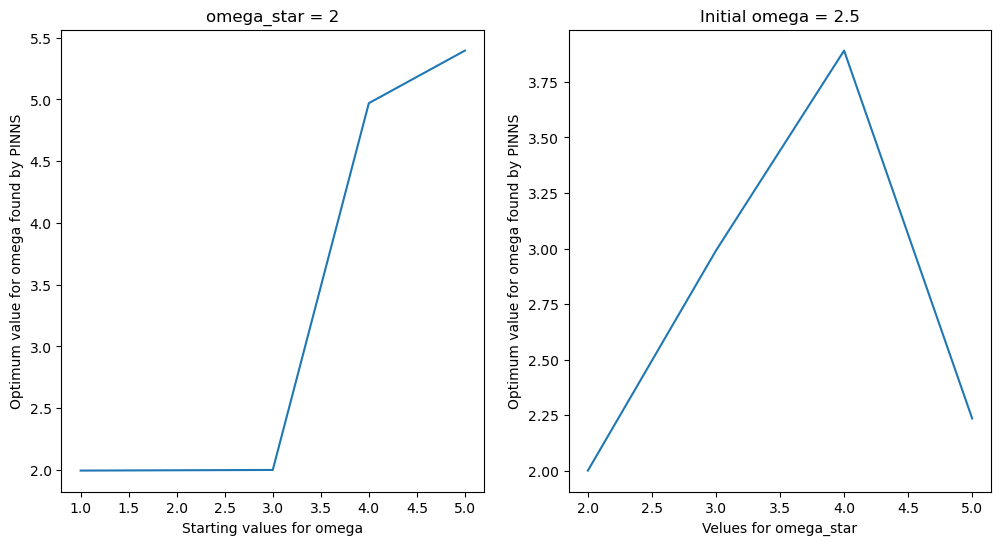

In [32]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(omegas, optimum_o)
plt.xlabel('Starting values for omega')
plt.ylabel('Optimum value for omega found by PINNS')
plt.title('omega_star = 2')

plt.subplot(122)
plt.plot(omega_stars, optimum_os)
plt.xlabel('Velues for omega_star')
plt.ylabel('Optimum value for omega found by PINNS')
plt.title('Initial omega = 2.5')

plt.show()

Idealy, the graph on the left must be constant line with y =2, and the graph on the right must be diagonal. 

But we see in practice, when $\omega^* =2$ for $\omega_0 > 3$ the optimum value of $\omega$ found by PINNS is very different from the expected value.

Similarly, when $\omega_0 = 2.5$ for $\omega_* > 4$ the optimum value of $\omega$ found by PINNS is very different from the expected value.

## Problem 2: Heat equation

$$w_t - \lambda w_{xx}=0,\qquad (x,t)\in (0,1)\times (0,1),$$
with initial condition
$$ w(x,0) = x^2+1,$$
and boundary conditions
$$ w(0,t) = 2\lambda t + 1\qquad \text{and}\qquad w(1,t)= 2\lambda t +2.$$
The exact solution is
$$w(x,t)=x^2 +2\lambda t+1.$$

* Use the following function to generate data points and learn the paramater $\lambda^*=0.5$.

In [22]:

def gen_data(num_pts=10, lmbda_star = 0.5):
    z = np.random.uniform(0, 1, [num_pts, 2])
    return z, z[:,0:1]**2 + 2*lmbda_star*z[:,1:2] + 1

In [24]:


geom = dde.geometry.Rectangle((0,0), (1, 1))
x_begin = 0; x_end = 1
def boundary_bottom(z,on_boundary):  
    return dde.utils.isclose(z[1],x_begin)


def boundary_top(z,on_boundary):  
    return dde.utils.isclose(z[1],x_end)


def ic_begin(z,on_boundary):
    return dde.utils.isclose(z[0],0)




def HEAT_PDE(L = tf.Variable(1.), LS = 0.5):
    
    Lambda = L; lmbda_star = LS
    
    bc_bottom = dde.icbc.DirichletBC (geom, lambda z: 2*Lambda*z[:,0:1] + 1, boundary_bottom)
    bc_top    = dde.icbc.DirichletBC (geom, lambda z: 2*Lambda*z[:,0:1] + 2, boundary_top)
    bc_ic     = dde.icbc.DirichletBC (geom, lambda z: (z[:,1:2])**2 + 1, ic_begin)
    
    points, ws = gen_data(lmbda_star = lmbda_star)
    observe   = dde.icbc.PointSetBC(points, ws)

    bcs = [bc_bottom,bc_top,bc_ic,observe]

    def HEAT_deepxde(z,w):
        dw_dt = dde.grad.jacobian(w,z,0,0)
        dw_dx = dde.grad.jacobian(w,z,0,1)
        d2w_dx2 = dde.grad.jacobian(dw_dx,z,0,1)
    
        return dw_dt - Lambda * d2w_dx2
    
    
    data = dde.data.PDE(geom, HEAT_deepxde,bcs, 
                        num_domain = 1200,
                        num_boundary = 5, 
                   anchors = points)
    
    net = dde.nn.FNN([2] + [50]*3 + [1], 'sin', 'He normal')
    parameters = dde.callbacks.VariableValue([Lambda], period=200)

    model = dde.Model(data, net)
    model.compile('adam', lr = 0.005, metrics = [])
    losshistory, train_state = model.train(iterations = 2000, callbacks=[parameters])
    
    return parameters.value


In [28]:
HEAT_PDE(L = tf.Variable(1.), LS = 0.5)

Compiling model...
Building feed-forward neural network...
'build' took 0.137427 s

'compile' took 1.321234 s

Training model...

0         [2.33e+01, 2.96e+00, 9.65e+00, 2.74e-03, 1.81e+00]    [2.33e+01, 2.96e+00, 9.65e+00, 2.74e-03, 1.81e+00]    []  
0 [1.00e+00]
200 [8.48e-01]
400 [7.35e-01]
600 [6.36e-01]
800 [5.65e-01]
1000      [4.23e-04, 7.80e-04, 2.29e-06, 1.74e-05, 7.67e-03]    [4.23e-04, 7.80e-04, 2.29e-06, 1.74e-05, 7.67e-03]    []  
1000 [5.19e-01]
1200 [4.90e-01]
1400 [4.71e-01]
1600 [4.58e-01]
1800 [4.49e-01]
2000      [2.04e-04, 2.06e-04, 5.74e-05, 8.78e-06, 5.18e-03]    [2.04e-04, 2.06e-04, 5.74e-05, 8.78e-06, 5.18e-03]    []  
2000 [4.45e-01]

Best model at step 2000:
  train loss: 5.66e-03
  test loss: 5.66e-03
  test metric: []

'train' took 34.713663 s



[0.44480014]

The optimal value found $\lambda = 0.49$ with the starting value $\lambda_0 = 1.0$. The expected value is $\lambda^* = 0.5$ which is pretty close.

In [33]:
gen_data(lmbda_star = 0.5)

(array([[0.59572352, 0.13216182],
        [0.61956248, 0.49872873],
        [0.10709652, 0.85674408],
        [0.39503539, 0.09590996],
        [0.80036973, 0.39633588],
        [0.75734126, 0.69341774],
        [0.86380651, 0.1990613 ],
        [0.91276126, 0.50546065],
        [0.57499384, 0.6148815 ],
        [0.53691117, 0.51729877]]),
 array([[1.48704833],
        [1.88258639],
        [1.86821375],
        [1.25196292],
        [2.03692758],
        [2.26698352],
        [1.94522299],
        [2.33859377],
        [1.94549941],
        [1.80557237]]))

In [33]:
lambdas = [1., 2., 3., 4.]
lambda_stars = [0.5, 1., 1.5, 2.]

optimum_l = []
for l in lambdas:
    
    opt = HEAT_PDE(L = tf.Variable(l), LS = 0.5)[0]
    optimum_l.append(opt)
    
optimum_ls = []
for ls in lambda_stars:
    
    opt = HEAT_PDE(L = tf.Variable(2.5), LS = ls)[0]
    optimum_ls.append(opt)

Compiling model...
Building feed-forward neural network...
'build' took 0.058238 s

'compile' took 1.799899 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [9.06e+00, 4.39e+00, 1.59e+01, 3.03e+00, 5.33e+00]    [9.06e+00, 4.39e+00, 1.59e+01, 3.03e+00, 5.33e+00]    []  
0 [1.00e+00]
200 [8.33e-01]
400 [7.43e-01]
600 [6.65e-01]
800 [6.05e-01]
1000      [3.56e-04, 1.38e-05, 1.29e-03, 7.52e-05, 1.22e-02]    [3.56e-04, 1.38e-05, 1.29e-03, 7.52e-05, 1.22e-02]    []  
1000 [5.67e-01]
1200 [5.45e-01]
1400 [5.30e-01]
1600 [5.21e-01]
1800 [5.15e-01]
2000      [3.06e-04, 1.88e-06, 4.91e-04, 2.09e-05, 9.54e-03]    [3.06e-04, 1.88e-06, 4.91e-04, 2.09e-05, 9.54e-03]    []  
2000 [5.09e-01]

Best model at step 2000:
  train loss: 1.04e-02
  test loss: 1.04e-02
  test metric: []

'train' took 33.834671 s

Compiling model...
Building feed-forward neural network...
'build' took 0.064858 s

'c

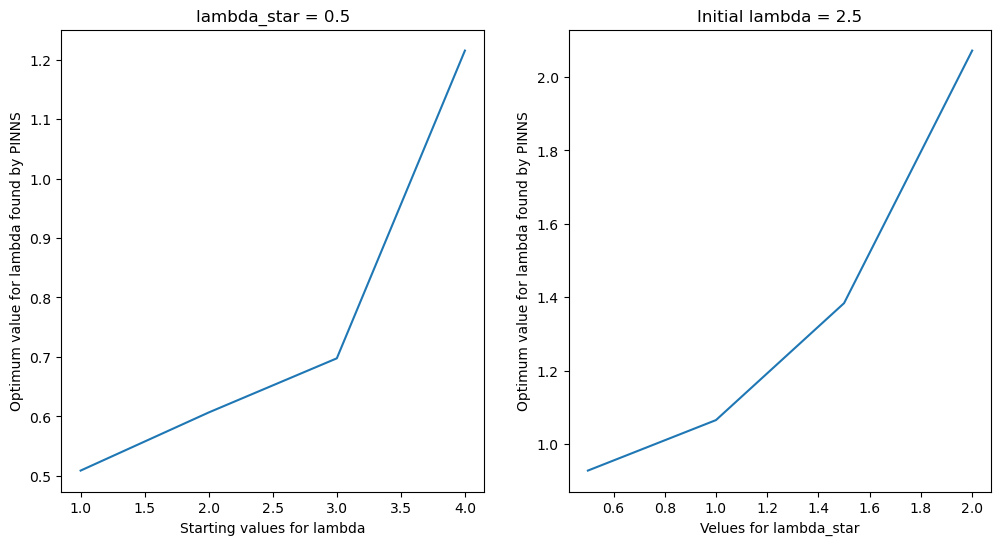

In [34]:
plt.figure(figsize=(12,6))

plt.subplot(121)
plt.plot(lambdas, optimum_l)
plt.xlabel('Starting values for lambda')
plt.ylabel('Optimum value for lambda found by PINNS')
plt.title('lambda_star = 0.5')

plt.subplot(122)
plt.plot(lambda_stars, optimum_ls)
plt.xlabel('Velues for lambda_star')
plt.ylabel('Optimum value for lambda found by PINNS')
plt.title('Initial lambda = 2.5')

plt.show()

Idealy, the graph on the left must be constant line with y = 0.5, and the graph on the right must be diagonal. 

But we see in practice, when $\lambda^* = 0.5$ the optimum value of $\lambda$ found by PINNS is very different from the expected values immediatly after $\lambda_0 >1.

Similarly, when $\lambda_0 = 2.5$ the graph of optimum value of $\lambda $ found by PINNS is very different from the diagonal line. 

We expect that for larger number of iterations and lower periods, one would get more reasonalble results.

## Problem 3: 

### A system of linear PDEs
Consider the system \begin{cases}
v_t - \frac{1}{2} v_{xx} = \alpha v +\beta w,\\
w_t - \frac{1}{2} w_{xx} = \gamma v + \delta w.
\end{cases}
with initial conditions
\begin{array}{l}
v(x,0) = x^2+1,\\
w(x,0) = 0,
\end{array}
and boundary conditions
\begin{array}{l}
v(0,t) = \left(t+1\right)e^{-t}, \\
v(1,t) = \left(t+2\right)e^{-t},\\
w(0,t) = \left(t+1\right)\left(e^{-t}-e^{-2t}\right), \\
w(1,t) = \left(t+2\right)\left(e^{-t}-e^{-2t}\right).
\end{array}

The exact solution of the system is
\begin{array}{l}
v(x,t)= \left(x^2 + t + 1\right)e^{- t},\\
w(x,t)= \left(x^2 + t + 1\right)\left(e^{- t}-  e^{-2t}\right).
\end{array}

The true parameters are
$$
\alpha^* =  -1, \quad \beta^* = 0, \quad \gamma^* = 1, \quad \delta^* =-2,$$


* Use data generated from the exact solution to leanr the parameters $\alpha, \beta, \gamma$ and $ \delta$.

In [4]:
x_max = 1
t_max = 1

def v_sol(X, T):
    return (X**2 + T + 1)*np.exp(-T)
def w_sol(X, T):
    return (X**2 + T + 1)*(np.exp(-T) - np.exp(-2*T))
def gen_data(num_pts=10):
    Z = np.random.uniform(0, 1, [num_pts, 2])
    v = v_sol(Z[:,:1], Z[:,1:])
    w = w_sol(Z[:,:1], Z[:,1:])
    return Z, np.stack([v.flatten(), w.flatten()], 1)

In [16]:

geom = dde.geometry.Rectangle((0,0), (1, 1))

x_begin = 0; x_end = 1
def boundary_bottom(z,on_boundary):  
    return dde.utils.isclose(z[1],x_begin)

def boundary_top(z,on_boundary):  
    return dde.utils.isclose(z[1],x_end)

def ic_begin(z,on_boundary):
    return dde.utils.isclose(z[0],0)


a = 0.5

bc_bottom_v = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 1)*tf.exp(-z[:,0:1])], boundary_bottom, component = 0)
bc_bottom_w = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 1)*(tf.exp(-z[:,0:1])-tf.exp(-2*z[:,0:1]))],boundary_bottom, component = 1)

bc_top_v    = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 2)*tf.exp(-z[:,0:1])],boundary_top, component = 0)
bc_top_w    = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 2)*(tf.exp(-z[:,0:1])-tf.exp(-2*z[:,0:1]))],boundary_top, component = 1)

points, Zs = gen_data(10)
obs_v = dde.icbc.PointSetBC(points, Zs[:,0:1],component = 0)
obs_w = dde.icbc.PointSetBC(points, Zs[:,1:2],component = 1)

bcs = [bc_top_v, bc_top_w, bc_bottom_v, bc_bottom_w, obs_v, obs_w]

def HEAT2_PDE(alpha = tf.Variable(-1.),
              beta = tf.Variable(0.), 
              gamma = tf.Variable(1.), 
              delta = tf.Variable(-2.)):

    def HEAT2_deepxde(z,y):
    
        v = y[:,0:1]
        w = y[:,1:2]
    
        dw_dt = dde.grad.jacobian(w,z,0,0)
        dw_dx = dde.grad.jacobian(w,z,0,1)
        d2w_dx2 = dde.grad.jacobian(dw_dx,z,0,1)
    
        dv_dt = dde.grad.jacobian(v,z,0,0)
        dv_dx = dde.grad.jacobian(v,z,0,1)
        d2v_dx2 = dde.grad.jacobian(dv_dx,z,0,1)
    
        return [
            dv_dt - a * d2v_dx2 - alpha*v - beta*w,
            dw_dt - a * d2w_dx2 - gamma*v - delta*w
            ]

    def output_transform(z, q): # With this transformation the initial conditions are automatically satisfied.
        v = q[:, 0:1]
        w = q[:, 1:2]
        t = z[:, 0:1]
        x = z[:, 1:2]
        return tf.concat([v * tf.tanh(t) + x**2+1, w * tf.tanh(t)], axis=1)


    data = dde.data.PDE(geom, HEAT2_deepxde,bcs, 
                        num_domain = 1500,
                        num_boundary = 6,
                   anchors = points)
    
    net = dde.nn.FNN([2] + [30]*3 + [2], 'sin', 'Glorot uniform')
    net.apply_output_transform(output_transform)
    parameters = dde.callbacks.VariableValue([alpha,beta,gamma,delta], period = 200)


    model = dde.Model(data, net)
    model.compile('adam', lr = 0.005, metrics = [])
    losshistory, train_state = model.train(iterations = 1000, callbacks = [parameters])
    
    return parameters.value

In [17]:
alphas = [-2., -1.5, -0.5, 0.]
betas  = [-1., -0.5, 0.5, 1.]
gammas = [0., 0.5, 1.5, 2.]
deltas  = [-3., -2.5, -1.5, -1.0]

optimum_a = []
for al in alphas:
    
    opt = HEAT2_PDE(alpha = tf.Variable(al))[0]
    optimum_a.append(opt)

optimum_b = []
for be in betas:
    
    opt = HEAT2_PDE(beta = tf.Variable(be))[1]
    optimum_b.append(opt)
    
optimum_g = []
for ga in gammas:
    
    opt = HEAT2_PDE(gamma = tf.Variable(ga))[2]
    optimum_g.append(opt)
    
optimum_d = []
for de in deltas:
    
    opt = HEAT2_PDE(delta = tf.Variable(de))[3]
    optimum_d.append(opt)

Compiling model...
Building feed-forward neural network...
'build' took 0.195520 s

'compile' took 7.131685 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [2.69e+00, 1.90e+00, 5.37e-01, 5.72e-01, 2.30e-03, 6.26e-02, 3.43e-01, 1.29e-01]    [2.69e+00, 1.90e+00, 5.37e-01, 5.72e-01, 2.30e-03, 6.26e-02, 3.43e-01, 1.29e-01]    []  
0 [-2.00e+00, 0.00e+00, 1.00e+00, -2.00e+00]
200 [-1.58e+00, 1.92e-01, 9.85e-01, -1.73e+00]
400 [-1.38e+00, 4.82e-01, 9.88e-01, -1.69e+00]
600 [-1.38e+00, 5.77e-01, 1.04e+00, -1.69e+00]
800 [-1.37e+00, 6.70e-01, 1.06e+00, -1.71e+00]
1000      [4.01e-03, 2.13e-03, 5.02e-03, 1.42e-05, 1.47e-02, 2.82e-03, 7.72e-02, 1.29e-02]    [4.01e-03, 2.13e-03, 5.02e-03, 1.42e-05, 1.47e-02, 2.82e-03, 7.72e-02, 1.29e-02]    []  
1000 [-1.37e+00, 7.76e-01, 1.08e+00, -1.72e+00]

Best model at step 1000:
  train

400 [-1.33e+00, 3.36e-01, 9.81e-01, -1.52e+00]
600 [-1.31e+00, 2.90e-01, 9.75e-01, -1.54e+00]
800 [-1.22e+00, 3.49e-01, 9.16e-01, -1.68e+00]
1000      [6.23e-03, 2.83e-03, 2.33e-03, 7.21e-04, 1.57e-02, 3.37e-03, 1.02e-01, 2.20e-02]    [6.23e-03, 2.83e-03, 2.33e-03, 7.21e-04, 1.57e-02, 3.37e-03, 1.02e-01, 2.20e-02]    []  
1000 [-1.13e+00, 5.63e-01, 8.98e-01, -1.80e+00]

Best model at step 1000:
  train loss: 1.55e-01
  test loss: 1.55e-01
  test metric: []

'train' took 39.866955 s

Compiling model...
Building feed-forward neural network...
'build' took 0.204968 s

'compile' took 7.281739 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [1.02e-01, 1.24e-01, 2.60e-01, 3.60e-01, 1.32e-02, 5.94e-02, 1.56e-01, 1.00e-01]    [1.02e-01, 1.24e-01, 2.60e-01, 3.60e-01, 1.32e-02, 5.94e-02, 1.56e-01, 1.00e-01]    []  
0 [-1.00e

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [3.02e-02, 1.52e+00, 1.80e-01, 3.37e-01, 2.81e-03, 9.97e-02, 1.95e-01, 1.07e-01]    [3.02e-02, 1.52e+00, 1.80e-01, 3.37e-01, 2.81e-03, 9.97e-02, 1.95e-01, 1.07e-01]    []  
0 [-1.00e+00, 0.00e+00, 1.00e+00, -1.00e+00]
200 [-1.18e+00, -2.81e-01, 8.55e-01, -9.83e-01]
400 [-1.14e+00, -2.11e-01, 8.64e-01, -1.02e+00]
600 [-1.09e+00, 4.34e-02, 8.53e-01, -1.16e+00]
800 [-1.23e+00, 1.98e-01, 9.49e-01, -1.21e+00]
1000      [4.24e-03, 2.19e-03, 3.11e-03, 4.81e-04, 1.91e-02, 4.79e-03, 8.29e-02, 1.33e-02]    [4.24e-03, 2.19e-03, 3.11e-03, 4.81e-04, 1.91e-02, 4.79e-03, 8.29e-02, 1.33e-02]    []  
1000 [-1.33e+00, 3.13e-01, 1.02e+00, -1.24e+00]

Best model at step 1000:
  train loss: 1.30e-01
  test loss: 1.30e-01
  test metric: []

'train' took 44.608932 s



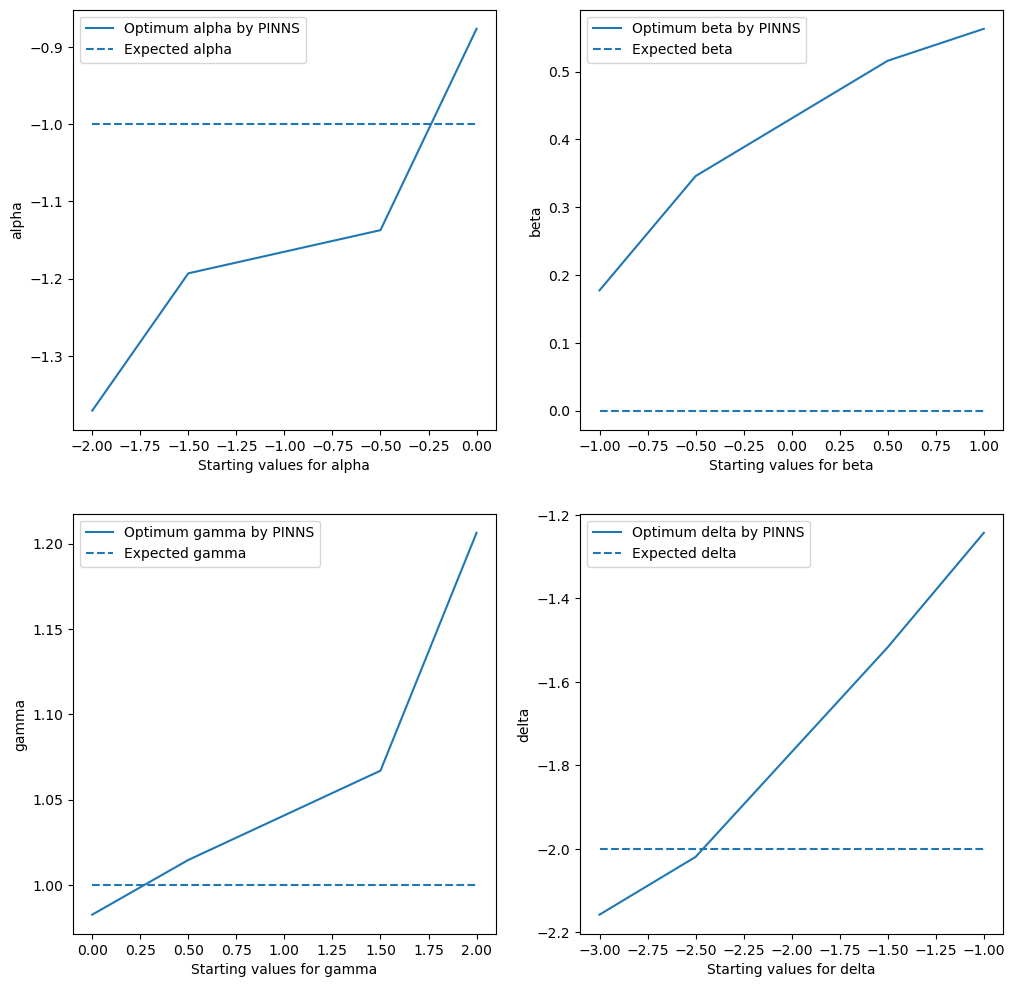

In [20]:
plt.figure(figsize=(12,12))

plt.subplot(221)
plt.plot(alphas, optimum_a, label = 'Optimum alpha by PINNS')
plt.hlines(-1, alphas[0], alphas[-1], linestyles='--', label='Expected alpha')
plt.xlabel('Starting values for alpha')
plt.ylabel('alpha')
plt.legend()

plt.subplot(222)
plt.plot(betas, optimum_b, label = 'Optimum beta by PINNS')
plt.hlines(0, betas[0], betas[-1], linestyles='--', label='Expected beta')
plt.xlabel('Starting values for beta')
plt.ylabel('beta')
plt.legend()

plt.subplot(223)
plt.plot(gammas, optimum_g, label = 'Optimum gamma by PINNS')
plt.hlines(1, gammas[0], gammas[-1], linestyles='--', label='Expected gamma')
plt.xlabel('Starting values for gamma')
plt.ylabel('gamma')
plt.legend()

plt.subplot(224)
plt.plot(deltas, optimum_d, label = 'Optimum delta by PINNS')
plt.hlines(-2, deltas[0], deltas[-1], linestyles='--', label='Expected delta')
plt.xlabel('Starting values for delta')
plt.ylabel('delta')
plt.legend()

plt.show()

In the graphs above, we fix three of four parameters at their true value and use PINNS to find optimum value for the other parameter for different starting values. 

We see that when for specific starting values one could get a good approximation of the true value, but this is genrally not the case.

## Problem 4:

### Hamilton-Jacobi equation

The goal is to see whether it is possible to learn $a$ and $b$ from data in the following equation \begin{array}{l}a \varphi_t+b\sin(x)\varphi_x = 0, \;  x\in[-\pi, \pi], \; t\in[0, 1], \\ \varphi(x, 0) = \sin(x), \\ \varphi(-\pi, t) = \varphi(\pi, t)= 0.  \end{array}

The true parameters we want to learn are $a^*=b^*=1$, for which the exact solution is
$$
\varphi(x,t) = \sin\left(2\arctan\left(e^{-t}\tan\left(\frac{x}{2} \right)\right)\right)
$$

1. Try learning $a$ and $b$ from data using the function above.
2. Can you explain the issue?

In [30]:
def gen_data(num_pts=100):
    X = np.random.uniform(-np.pi, np.pi, num_pts)
    T = np.random.uniform(0, 1, num_pts)
    return np.stack([X,T], 1), np.sin(2*np.arctan(np.exp(-T)*np.tan(X/2))).reshape(num_pts, 1)

def phi_exact(z):
    t = z[:,1:2]
    x = z[:,0:1]
    
    return np.sin(2*np.arctan(np.exp(-t)*np.tan(x/2)))

In [31]:
# PINNS Solution:

t_max = 1; t_min = 0
x_max = np.pi; x_min = -np.pi
x = np.linspace(x_min, x_max, 100)
t = np.linspace(t_min, t_max, 100)
X, T = np.meshgrid(x, t)

geom = dde.geometry.Rectangle((x_min,t_min), (x_max,t_max))

def boundary_bottom(z,on_boundary):  
    return dde.utils.isclose(z[0],x_min)

def boundary_top(z,on_boundary):  
    return dde.utils.isclose(z[0],x_max)


bc_min_x = dde.icbc.DirichletBC (geom, lambda z: 0, boundary_bottom, component = 0)
bc_max_x = dde.icbc.DirichletBC (geom, lambda z: 0, boundary_top,    component = 0)

points, phis = gen_data()
obs_phi = dde.icbc.PointSetBC(points, phis,component = 0)

bcs = [bc_min_x, bc_max_x, obs_phi]

def HJ_PDE(a_in, b_in, iter_in):
    
    iters = iter_in
    a = tf.Variable(a_in)
    b = tf.Variable(b_in)
    
    def HJ_deepxde(z,y):
    
        phi = y[:, 0:1]
        x = z[:, 0:1]
        t = z[:, 1:2]
    
        dphi_dt = dde.grad.jacobian(phi,z,0,1)
        dphi_dx = dde.grad.jacobian(phi,z,0,0)
    
    
        return a*dphi_dt  + b*tf.sin(x) * dphi_dx

    def output_transform(z, q): # Here we applied the initial conditions as 'Hard constraints'
        phi = q[:, 0:1]
    
        x = z[:, 0:1]
        t = z[:, 1:2]
    
        return phi * tf.tanh(t) + tf.sin(x)

    data = dde.data.PDE(geom, HJ_deepxde,bcs, 
                        num_domain = 2000,
                        num_boundary = 45,
                        anchors = points,
                        num_test = 50
                       )
                       
    net = dde.nn.FNN([2] + [40]*3 + [1], 'tanh', 'He normal')
    net.apply_output_transform(output_transform)
    parameters = dde.callbacks.VariableValue([a, b], period = 200)

    model = dde.Model(data, net)
    model.compile('adam', lr = 0.005, metrics = [])
    
    
    losshistory, train_state = model.train(iterations = iters, callbacks = [parameters])
    
    Z_pred = model.predict(np.stack((X.ravel(), T.ravel()), axis=-1)).reshape(len(x), len(t),1)
    Z_true = phi_exact(np.stack((X.ravel(), T.ravel()), axis = -1)).reshape(len(x), len(t),1)
    
    err = dde.metrics.l2_relative_error(Z_true,Z_pred)
    
    return parameters.value, err

In [32]:
As = [0.7, 1., 1.3]
Bs = [0.7, 1., 1.3]

iter_num = [1000, 1200, 1400, 1600, 1800, 2000, 2200]

iter_a = []
err_a  = [] 
for a in As:
    for it in iter_num:
        opt, err = HJ_PDE(a_in=a, b_in=1., iter_in = it)
        iter_a.append(opt[0])
        err_a.append(err)

iter_b = []
err_b  = []
for b in Bs:
    for it in iter_num:
        opt, err = HJ_PDE(a_in=1., b_in=b, iter_in = it)
        iter_b.append(opt[1])
        err_b.append(err)


Compiling model...
Building feed-forward neural network...
'build' took 0.682251 s

'compile' took 5.348308 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.46e-01, 7.11e-02, 2.25e-03, 2.52e-01]    [3.74e-01, 7.11e-02, 2.25e-03, 2.52e-01]    []  
0 [7.00e-01, 1.00e+00]
200 [6.88e-01, 4.70e-01]
400 [5.32e-01, 3.90e-01]
600 [4.11e-01, 3.67e-01]
800 [3.57e-01, 3.43e-01]
1000      [9.22e-04, 3.55e-03, 1.48e-02, 2.40e-03]    [7.52e-04, 3.55e-03, 1.48e-02, 2.40e-03]    []  
1000 [3.30e-01, 3.23e-01]

Best model at step 1000:
  train loss: 2.17e-02
  test loss: 2.15e-02
  test metric: []

'train' took 21.878651 s

Compiling model...
Building feed-forward neural network...
'build' took 0.133566 s

'compile' took 4.466806 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.56e-01, 1.66e-02, 1.09e-01, 1.35e-01

Compiling model...
Building feed-forward neural network...
'build' took 0.405158 s

'compile' took 4.560438 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [5.40e-01, 1.45e-01, 3.07e-01, 1.41e-01]    [5.31e-01, 1.45e-01, 3.07e-01, 1.41e-01]    []  
0 [1.00e+00, 1.00e+00]
200 [9.06e-01, 4.60e-01]
400 [7.44e-01, 4.14e-01]
600 [5.64e-01, 4.04e-01]
800 [4.21e-01, 3.49e-01]
1000      [5.34e-04, 1.43e-05, 4.40e-05, 8.55e-04]    [4.44e-04, 1.43e-05, 4.40e-05, 8.55e-04]    []  
1000 [3.17e-01, 2.85e-01]
1200 [2.46e-01, 2.36e-01]
1400      [1.66e-04, 4.37e-06, 1.21e-05, 2.41e-04]    [1.11e-04, 4.37e-06, 1.21e-05, 2.41e-04]    []  
1400 [1.90e-01, 1.85e-01]

Best model at step 1400:
  train loss: 4.24e-04
  test loss: 3.69e-04
  test metric: []

'train' took 26.402244 s

Compiling model...
Building feed-forward neural network...
'build' took 0.170232 s

'compile' took 3.251288 s

Training model...

Step

1400 [5.16e-01, 4.70e-01]
1600      [3.36e-04, 4.52e-06, 2.18e-05, 3.01e-04]    [3.19e-04, 4.52e-06, 2.18e-05, 3.01e-04]    []  
1600 [4.40e-01, 4.06e-01]

Best model at step 1600:
  train loss: 6.63e-04
  test loss: 6.46e-04
  test metric: []

'train' took 31.487823 s

Compiling model...
Building feed-forward neural network...
'build' took 0.330779 s

'compile' took 5.081003 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.09e-01, 8.15e-02, 1.70e-01, 1.25e-01]    [7.96e-01, 8.15e-02, 1.70e-01, 1.25e-01]    []  
0 [1.30e+00, 1.00e+00]
200 [1.19e+00, 4.94e-01]
400 [1.05e+00, 4.39e-01]
600 [8.50e-01, 4.76e-01]
800 [6.44e-01, 4.53e-01]
1000      [1.69e-03, 5.17e-05, 2.12e-04, 2.62e-03]    [1.50e-03, 5.17e-05, 2.12e-04, 2.62e-03]    []  
1000 [4.80e-01, 3.97e-01]
1200 [3.68e-01, 3.29e-01]
1400 [2.85e-01, 2.63e-01]
1600 [2.26e-01, 2.18e-01]
1800      [1.10e-04, 2.26e-06, 8.20e-06, 1.92e-04]    [7

0 [1.00e+00, 7.00e-01]
200 [7.82e-01, 3.05e-01]
400 [4.58e-01, 2.56e-01]
600 [1.73e-01, 1.30e-01]
800 [3.36e-02, 2.99e-02]
1000      [3.25e-07, 4.46e-05, 7.33e-06, 2.30e-03]    [2.78e-07, 4.46e-05, 7.33e-06, 2.30e-03]    []  
1000 [3.73e-03, 3.21e-03]
1200 [3.44e-04, 3.40e-04]
1400 [3.03e-05, 3.00e-05]
1600 [2.45e-06, 2.41e-06]
1800 [2.07e-07, 1.96e-07]
2000      [5.77e-18, 6.40e-06, 9.29e-06, 3.73e-04]    [2.71e-18, 6.40e-06, 9.29e-06, 3.73e-04]    []  
2000 [1.81e-08, 1.83e-08]

Best model at step 2000:
  train loss: 3.88e-04
  test loss: 3.88e-04
  test metric: []

'train' took 44.555014 s

Compiling model...
Building feed-forward neural network...
'build' took 1.181676 s

'compile' took 11.665940 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [6.34e-01, 8.91e-02, 3.22e-02, 1.49e-01]    [6.66e-01, 8.91e-02, 3.22e-02, 1.49e-01]    []  
0 [1.00e+00, 7.00e-01]
200 [8.82e-01, 3.15e-01]
400 [7.

2200 [3.31e-01, 3.24e-01]

Best model at step 2000:
  train loss: 1.03e-04
  test loss: 6.95e-05
  test metric: []

'train' took 52.348735 s

Compiling model...
Building feed-forward neural network...
'build' took 1.291746 s

'compile' took 13.182342 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.50e-01, 2.11e-01, 6.16e-02, 9.78e-02]    [3.27e-01, 2.11e-01, 6.16e-02, 9.78e-02]    []  
0 [1.00e+00, 1.30e+00]
200 [1.09e+00, 6.96e-01]
400 [9.73e-01, 6.06e-01]
600 [7.98e-01, 6.25e-01]
800 [6.93e-01, 6.03e-01]
1000      [5.67e-04, 2.99e-05, 1.95e-05, 3.70e-04]    [5.55e-04, 2.99e-05, 1.95e-05, 3.70e-04]    []  
1000 [6.28e-01, 5.68e-01]

Best model at step 1000:
  train loss: 9.87e-04
  test loss: 9.75e-04
  test metric: []

'train' took 48.417022 s

Compiling model...
Building feed-forward neural network...
'build' took 1.102509 s

'compile' took 14.245086 s

Training model...

Step      Train

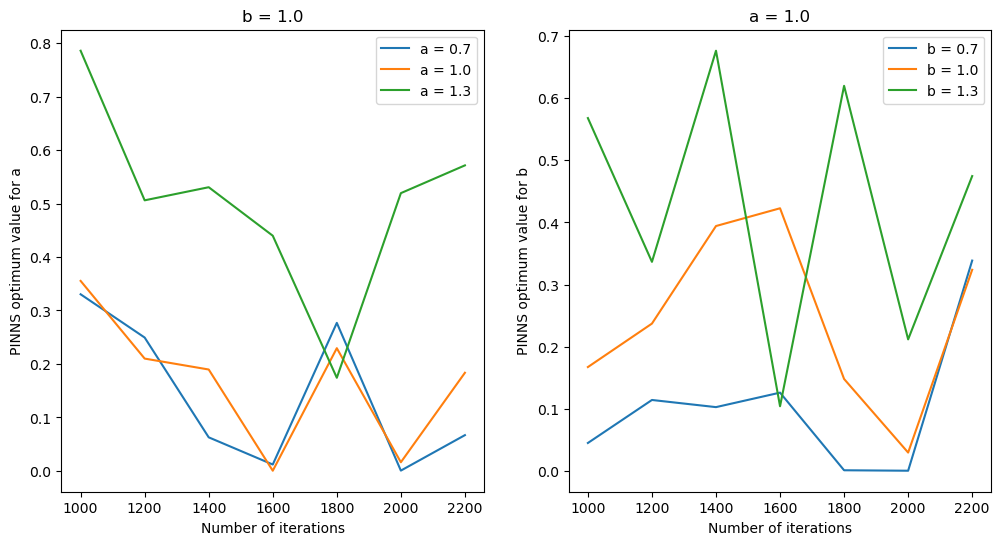

In [33]:
iters_a = np.array(iter_a).reshape(3,7)
iters_b = np.array(iter_b).reshape(3,7)

plt.figure(figsize = (12,6))

plt.subplot(121)
for i in range(len(As)):
    plt.plot(iter_num, iters_a[i,:], label = 'a = {}'.format(As[i]))
plt.xlabel('Number of iterations')
plt.ylabel('PINNS optimum value for a')
plt.title('b = 1.0')
plt.legend()

plt.subplot(122)
for i in range(len(Bs)):
    plt.plot(iter_num, iters_b[i,:], label = 'b = {}'.format(Bs[i]))
plt.xlabel('Number of iterations')
plt.ylabel('PINNS optimum value for b')
plt.title('a = 1.0')
plt.legend()

plt.show()

This graphs shows (a,b) values don't converge to the expected point  $(a^*,b^*) = (1,1)$.

The follwing graphs for mean_error versus the values of (a,b) shows the point (1,1) is not a minimum of the l2_error function.

#### In this graph the blue line is the l2_relative error for different valuse of 'a' in the set [0.7, 1, 1.3]
#### Similarly, the orange line is the l2_relative error for different valuse of 'b' in the set [0.7, 1, 1.3]

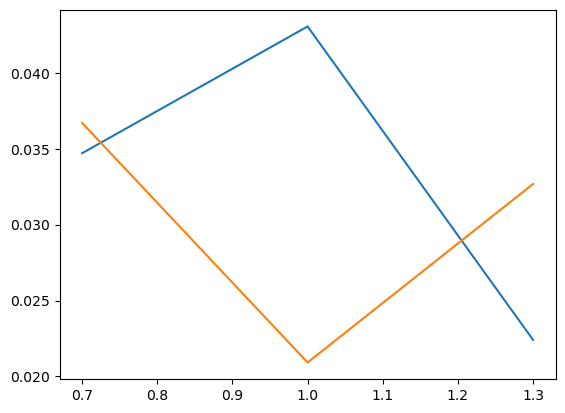

In [37]:
mean_err_a = [np.mean(err_a[i,:]) for i in range(len(As))]
mean_err_b = [np.mean(err_b[i,:]) for i in range(len(Bs))]

plt.plot(As, mean_err_a)
plt.plot(Bs, mean_err_b)

# Part 3: Parameter Identification with noise

### Problem 1: Simple ODE

$$\frac{dy}{dx} =\cos(\omega x), \quad x\in [-\pi , \pi],$$
with $y(0)=0$.

The exact solution is $y(x)=\frac{1}{\omega}\sin(\omega x)$.

* Use the following function to generate data points and learn the paramater $\omega^*=2$. Try with different levels of noise. Use the parameter `eps` to set the amplitude of the noise.

In [3]:
omega_star = 2
x_max = 2*np.pi

def gen_data(eps=0.1):
    x = np.random.uniform(0, x_max, [10, 1])
    noise = eps*np.random.uniform(-1, 1, [10, 1])
    return x, np.sin(omega_star*x)/omega_star + noise

In [5]:
def noisy_params(eps, omega_0 = 1.): # We train the FNN with different values of noise amplitudes. We'll plot the final values for
                       # for Omega in each case. These numbers are close to the expected values...

    omega = tf.Variable(omega_0)
    
    geom = dde.geometry.TimeDomain(-np.pi, np.pi)

    x_begin = 0; y_begin = 0
    def boundary_begin(x,_):  
        return dde.utils.isclose(x[0],x_begin)

    def bc_func_begin(x,y,_): 
        return y - y_begin

    bc1 = dde.icbc.OperatorBC(geom,bc_func_begin,boundary_begin)

    points, ys = gen_data(eps)
    observe = dde.icbc.PointSetBC(points, ys )

    bcs = [bc1, observe]


    def ODE_deepxde(x,y):
        dy_dx = dde.grad.jacobian(y,x)
    
        return dy_dx - tf.cos(omega*x)
                
    data = dde.data.PDE(geom, ODE_deepxde,bcs, 
                        num_domain = 1000,
                        num_boundary = 1, 
                        num_test = 200,
                       anchors = points)

    net = dde.nn.FNN([1] + [60]*4 + [1], 'tanh', 'He uniform')
    model = dde.Model(data, net)
    
    parameters = dde.callbacks.VariableValue([omega], period=200)
    
    
    model.compile('adam', lr = 0.005, metrics = [])
    losshistory, train_state = model.train(iterations = 1000, callbacks=[parameters])

    
    return parameters.value

Compiling model...
Building feed-forward neural network...
'build' took 0.226469 s

'compile' took 1.382866 s

Training model...

0         [7.26e-01, 0.00e+00, 3.17e-01]    [7.28e-01, 0.00e+00, 3.17e-01]    []  
0 [1.00e+00]
200 [1.02e+00]
400 [1.92e+00]
600 [1.99e+00]
800 [1.99e+00]
1000      [3.11e-04, 1.42e-07, 4.67e-05]    [1.86e-04, 1.42e-07, 4.67e-05]    []  
1000 [1.99e+00]

Best model at step 1000:
  train loss: 3.58e-04
  test loss: 2.33e-04
  test metric: []

'train' took 8.212533 s

Compiling model...
Building feed-forward neural network...
'build' took 0.136385 s

'compile' took 1.634719 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.10e+00, 0.00e+00, 1.13e-01]    [1.12e+00, 0.00e+00, 1.13e-01]    []  
0 [1.00e+00]
200 [7.24e-01]
400 [8.35e-01]
600 [9.49e-01]
800 [1.90e+00]
1000      [9.21e-04, 3.05e-08, 1.55e-03]    [1.21e-04, 3.05e-08, 1.55e-03]    []  
1000 [1.94e+00]

Best model at step 1000:

'build' took 0.119791 s

'compile' took 3.057362 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.50e+00, 0.00e+00, 4.57e-01]    [1.54e+00, 0.00e+00, 4.57e-01]    []  
0 [2.00e+00]
200 [1.69e+00]
400 [2.08e+00]
600 [2.13e+00]
800 [2.13e+00]
1000      [2.79e-04, 8.60e-06, 4.59e-03]    [1.80e-04, 8.60e-06, 4.59e-03]    []  
1000 [2.14e+00]

Best model at step 1000:
  train loss: 4.88e-03
  test loss: 4.78e-03
  test metric: []

'train' took 13.401438 s

Compiling model...
Building feed-forward neural network...
'build' took 0.070046 s

'compile' took 1.722689 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.50e-01, 0.00e+00, 1.16e+00]    [5.47e-01, 0.00e+00, 1.16e+00]    []  
0 [2.00e+00]
200 [1.89e+00]
400 [1.90e+00]
600 [1.91e+00]
800 [1.90e+00]
1000      [3.78e-03, 2.73e-05, 2.99e-02]    [1.00e-03, 2.73e-05, 2.99e-02]    []  
1000 [1.9

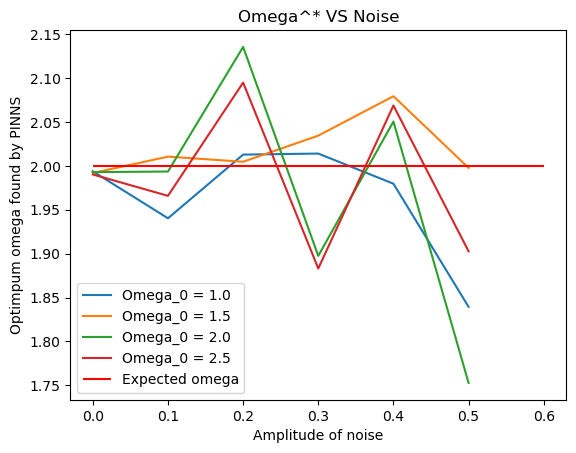

In [8]:
for omega_0 in [1., 1.5, 2., 2.5]:

    omega_vals = [] 
    for e in np.linspace(0,0.5,6):
        val = noisy_params(e, omega_0 = omega_0)
        omega_vals.append(val)
    plt.plot(np.linspace(0,0.5,6), omega_vals, label = 'Omega_0 = {}'.format(omega_0))

plt.hlines(2, 0, 0.6, color = 'r', label='Expected omega')
plt.ylabel('Optimpum omega found by PINNS')
plt.xlabel('Amplitude of noise')
plt.title('Omega^* VS Noise')
plt.legend()

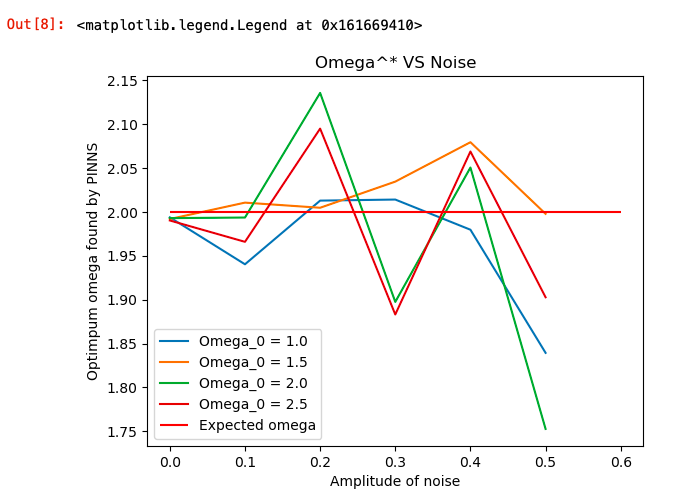

From the graph above for different values of $\omega_0$, the value of $\omega$ found by PINNS diverges from the true value $\omega_0$. 

### Problem  2: Heat equation

$$w_t - \lambda w_{xx}=0,\qquad (x,t)\in (0,1)\times (0,1),$$
with initial condition
$$ w(x,0) = x^2+1,$$
and boundary conditions
$$ w(0,t) = 2\lambda t + 1\qquad \text{and}\qquad w(1,t)= 2\lambda t +2.$$
The exact solution is
$$w(x,t)=x^2 +2\lambda t+1.$$

* Use the following function to generate data points and learn the paramater $\lambda^*=0.5$.

* Try with different `eps`.

In [3]:
lmbda_star = 0.5

def gen_data(eps=0.1):
    z = np.random.uniform(0, 1, [10, 2])
    noise = eps*np.random.uniform(-1, 1, [10, 1])

    return z, z[:,0:1]**2 + 2*lmbda_star*z[:,1:2] + 1 + noise

In [6]:
def noisy_params(eps, Lambda_0 = 1.5):
    Lambda = tf.Variable(Lambda_0)

    geom = dde.geometry.Rectangle((0,0), (1, 1))
    x_begin = 0; x_end = 1
    def boundary_bottom(z,on_boundary):  
        return dde.utils.isclose(z[1],x_begin)

    def boundary_top(z,on_boundary):  
        return dde.utils.isclose(z[1],x_end)

    def ic_begin(z,on_boundary):
        return dde.utils.isclose(z[0],0)


    bc_bottom = dde.icbc.DirichletBC (geom, lambda z: 2*Lambda*z[:,0:1] + 1, boundary_bottom)
    bc_top    = dde.icbc.DirichletBC (geom, lambda z: 2*Lambda*z[:,0:1] + 2, boundary_top)
    bc_ic     = dde.icbc.DirichletBC (geom, lambda z: (z[:,1:2])**2 + 1, ic_begin)

    points, ws = gen_data(eps)
    observe   = dde.icbc.PointSetBC(points, ws)

    bcs = [bc_bottom,bc_top,bc_ic,observe]

    def HEAT_deepxde(z,w):
        dw_dt = dde.grad.jacobian(w,z,0,0)
        dw_dx = dde.grad.jacobian(w,z,0,1)
        d2w_dx2 = dde.grad.jacobian(dw_dx,z,0,1)
    
        return dw_dt - Lambda * d2w_dx2
    
    
    data = dde.data.PDE(geom, HEAT_deepxde,bcs, 
                        num_domain = 1000,
                        num_boundary = 6, 
                       anchors = points)
    
    net = dde.nn.FNN([2] + [60]*4 + [1], 'tanh', 'He uniform')
    parameters = dde.callbacks.VariableValue([Lambda], period=200)

    model = dde.Model(data, net)
    model.compile('adam', lr = 0.005, metrics = [])
    losshistory, train_state = model.train(iterations = 1000, callbacks=[parameters])
    
    return parameters.value

In [12]:
out = []
for l0 in [0.75, 1., 0.5, 0.25]:
    
    Lambda_vals = [] 
    for e in np.linspace(0,0.5,6):
        val = noisy_params(e, l0)
        Lambda_vals.append(val)
    out.append(Lambda_vals)

Compiling model...
Building feed-forward neural network...
'build' took 0.078642 s

'compile' took 2.325318 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [2.43e+00, 1.64e+00, 6.32e+00, 3.21e-01, 1.92e+00]    [2.43e+00, 1.64e+00, 6.32e+00, 3.21e-01, 1.92e+00]    []  
0 [7.50e-01]
200 [6.17e-01]
400 [5.82e-01]
600 [5.56e-01]
800 [5.38e-01]
1000      [1.69e-04, 2.94e-04, 2.43e-04, 8.69e-06, 1.15e-02]    [1.69e-04, 2.94e-04, 2.43e-04, 8.69e-06, 1.15e-02]    []  
1000 [5.29e-01]

Best model at step 1000:
  train loss: 1.23e-02
  test loss: 1.23e-02
  test metric: []

'train' took 19.496251 s

Compiling model...
Building feed-forward neural network...
'build' took 0.113134 s

'compile' took 2.325574 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.06e+01, 6.51e+00

0 [1.00e+00]
200 [7.95e-01]
400 [6.60e-01]
600 [5.40e-01]
800 [4.57e-01]
1000      [9.25e-04, 9.41e-04, 9.94e-05, 1.63e-03, 6.10e-02]    [9.25e-04, 9.41e-04, 9.94e-05, 1.63e-03, 6.10e-02]    []  
1000 [4.06e-01]

Best model at step 1000:
  train loss: 6.46e-02
  test loss: 6.46e-02
  test metric: []

'train' took 30.663324 s

Compiling model...
Building feed-forward neural network...
'build' took 0.105927 s

'compile' took 4.188399 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [2.70e+00, 6.68e-01, 4.73e+00, 5.31e-01, 1.71e+00]    [2.70e+00, 6.68e-01, 4.73e+00, 5.31e-01, 1.71e+00]    []  
0 [5.00e-01]
200 [4.56e-01]
400 [4.95e-01]
600 [5.08e-01]
800 [5.13e-01]
1000      [2.08e-03, 1.98e-03, 1.06e-02, 3.60e-03, 1.24e-02]    [2.08e-03, 1.98e-03, 1.06e-02, 3.60e-03, 1.24e-02]    []  
1000 [5.13e-01]

Best model at step 1000:
  train loss: 3.06e-02
  test loss: 3.06e-02
  test

'compile' took 3.640999 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [3.46e+00, 1.05e-01, 3.41e+00, 1.67e+00, 1.71e+00]    [3.46e+00, 1.05e-01, 3.41e+00, 1.67e+00, 1.71e+00]    []  
0 [2.50e-01]
200 [2.65e-01]
400 [3.36e-01]
600 [3.65e-01]
800 [3.82e-01]
1000      [2.64e-04, 7.65e-05, 2.10e-05, 1.13e-05, 1.51e-02]    [2.64e-04, 7.65e-05, 2.10e-05, 1.13e-05, 1.51e-02]    []  
1000 [3.89e-01]

Best model at step 1000:
  train loss: 1.55e-02
  test loss: 1.55e-02
  test metric: []

'train' took 29.474204 s



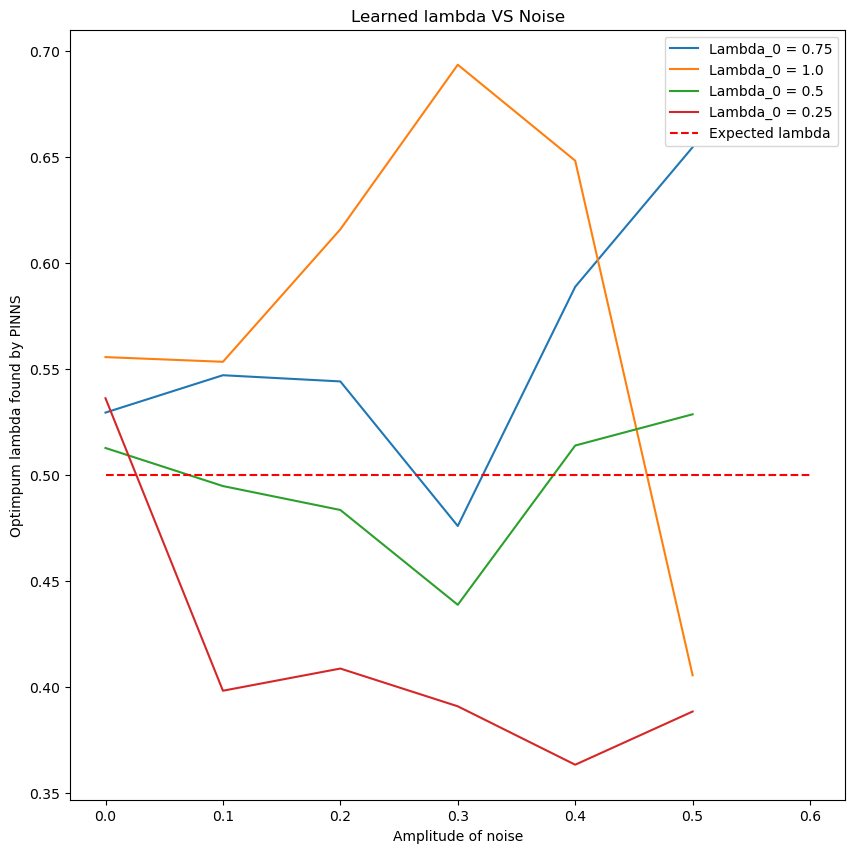

In [13]:
plt.figure(figsize=(10,10))
Lambda_0_vals = [0.75, 1., 0.5, 0.25]
for i in range(4):
    
    plt.plot(np.linspace(0,0.5,6), out[i], label = 'Lambda_0 = {}'.format(Lambda_0_vals[i]))

plt.hlines(0.5, 0, 0.6, color = 'r',linestyles = '--', label='Expected lambda')
plt.ylabel('Optimpum lambda found by PINNS')
plt.xlabel('Amplitude of noise')
plt.title('Learned lambda VS Noise')
plt.legend()

plt.show()

As the value of the noise amplitude increases, the value of $\lambda$ learned by PINNS diverges from the expected value.

### Problem 3: A system of linear PDEs

Consider the system \begin{cases}
v_t - \frac{1}{2} v_{xx} = \alpha v +\beta w,\\
w_t - \frac{1}{2} w_{xx} = \gamma v + \delta w.
\end{cases}
with initial conditions
\begin{array}{l}
v(x,0) = x^2+1,\\
w(x,0) = 0,
\end{array}
and boundary conditions
\begin{array}{l}
v(0,t) = \left(t+1\right)e^{-t}, \\
v(1,t) = \left(t+2\right)e^{-t},\\
w(0,t) = \left(t+1\right)\left(e^{-t}-e^{-2t}\right), \\
w(1,t) = \left(t+2\right)\left(e^{-t}-e^{-2t}\right).
\end{array}
The true parameters are
$$
\alpha^* =  -1, \quad \beta^* = 0, \quad \gamma^* = 1, \quad \delta^* =-2,
$$ and the exact solution of the system is
\begin{array}{l}
v(x,t)= \left(x^2 + t + 1\right)e^{- t},\\
w(x,t)= \left(x^2 + t + 1\right)\left(e^{- t}-  e^{-2t}\right).
\end{array}

* Use noisy data to learn $\alpha, \beta, \gamma$ and $ \delta$. Try with different values of `eps`.

In [3]:
x_max = 1
t_max = 1

def v_sol(X, T):
    return (X**2 + T + 1)*np.exp(-T)
def w_sol(X, T):
    return (X**2 + T + 1)*(np.exp(-T) - np.exp(-2*T))

def gen_data(eps=0.05):
    Z = np.random.uniform(0, 1, [10, 2])
    v = v_sol(Z[:,:1], Z[:,1:])
    w = w_sol(Z[:,:1], Z[:,1:])
    noise = eps*np.random.uniform(-1, 1, [10, 2])

    return Z, np.stack([v.flatten(), w.flatten()], 1) + noise

In [5]:
def noisy_params(eps):
    alpha = tf.Variable(-0.5)
    beta  = tf.Variable(0.2)
    gamma = tf.Variable(1.2)
    delta = tf.Variable(-2.2)

    geom = dde.geometry.Rectangle((0,0), (1, 1))

    x_begin = 0; x_end = 1
    def boundary_bottom(z,on_boundary):  
        return dde.utils.isclose(z[1],x_begin)

    def boundary_top(z,on_boundary):  
        return dde.utils.isclose(z[1],x_end)

    def ic_begin(z,on_boundary):
        return dde.utils.isclose(z[0],0)


    a = 0.5

    bc_bottom_v = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 1)*tf.exp(-z[:,0:1])], boundary_bottom, component = 0)
    bc_bottom_w = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 1)*(tf.exp(-z[:,0:1])-tf.exp(-2*z[:,0:1]))],boundary_bottom, component = 1)

    bc_top_v    = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 2)*tf.exp(-z[:,0:1])],boundary_top, component = 0)
    bc_top_w    = dde.icbc.DirichletBC (geom, lambda z: [(2*a*z[:,0:1] + 2)*(tf.exp(-z[:,0:1])-tf.exp(-2*z[:,0:1]))],boundary_top, component = 1)

    points, Zs = gen_data(eps)
    obs_v = dde.icbc.PointSetBC(points, Zs[:,0:1],component = 0)
    obs_w = dde.icbc.PointSetBC(points, Zs[:,1:2],component = 1)

    bcs = [bc_top_v, bc_top_w, bc_bottom_v, bc_bottom_w, obs_v, obs_w]


    def HEAT2_deepxde(z,y):
    
        v = y[:,0:1]
        w = y[:,1:2]
    
        dw_dt = dde.grad.jacobian(w,z,0,0)
        dw_dx = dde.grad.jacobian(w,z,0,1)
        d2w_dx2 = dde.grad.jacobian(dw_dx,z,0,1)
    
        dv_dt = dde.grad.jacobian(v,z,0,0)
        dv_dx = dde.grad.jacobian(v,z,0,1)
        d2v_dx2 = dde.grad.jacobian(dv_dx,z,0,1)
    
        return [
            dv_dt - a * d2v_dx2 - alpha*v - beta*w,
            dw_dt - a * d2w_dx2 - gamma*v - delta*w
        ]

    def output_transform(z, q):
        v = q[:, 0:1]
        w = q[:, 1:2]
        t = z[:, 0:1]
        x = z[:, 1:2]
        return tf.concat([v * tf.tanh(t) + x**2+1, w * tf.tanh(t)], axis=1)


    data = dde.data.PDE(geom, HEAT2_deepxde,bcs, 
                            num_domain = 1000,
                            num_boundary = 6,
                            num_test=100,
                       anchors = points)
    
    net = dde.nn.FNN([2] + [60]*4 + [2], 'tanh', 'He uniform')
    net.apply_output_transform(output_transform)
    parameters = dde.callbacks.VariableValue([alpha,beta,gamma,delta], period = 200)


    model = dde.Model(data, net)
    model.compile('adam', lr = 0.005, metrics = [])
    losshistory, train_state = model.train(iterations = 1000, callbacks = [parameters])
    
    return parameters.value

In [6]:
alpha_vals = []
beta_vals = []
gamma_vals = []
delta_vals = []
for e in np.linspace(0,0.5,6):
    val = noisy_params(e)
    alpha_vals.append(val[0])
    beta_vals.append(val[1])
    gamma_vals.append(val[2])
    delta_vals.append(val[3])

Compiling model...
Building feed-forward neural network...
'build' took 0.103256 s

'compile' took 2.676728 s



2024-09-30 19:04:10.286009: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled


Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [7.78e-01, 4.35e+00, 6.02e-01, 3.67e-01, 1.02e-01, 4.37e-02, 2.67e-01, 1.52e-01]    [7.34e-01, 4.29e+00, 6.02e-01, 3.67e-01, 1.02e-01, 4.37e-02, 2.67e-01, 1.52e-01]    []  
0 [-5.00e-01, 2.00e-01, 1.20e+00, -2.20e+00]
200 [-7.43e-01, 1.12e-01, 1.18e+00, -2.16e+00]
400 [-7.20e-01, 2.07e-01, 1.17e+00, -2.17e+00]
600 [-6.81e-01, 3.20e-01, 1.16e+00, -2.18e+00]
800 [-6.35e-01, 4.35e-01, 1.14e+00, -2.19e+00]
1000      [1.05e-02, 3.44e-04, 8.31e-03, 6.41e-05, 9.01e-03, 9.55e-04, 7.22e-02, 1.43e-02]    [8.34e-03, 2.52e-04, 8.31e-03, 6.41e-05, 9.01e-03, 9.55e-04, 7.22e-02, 1.43e-02]    []  
1000 [-6.01e-01, 5.37e-01, 1.12e+00, -2.20e+00]

Best model at step 1000:
  train loss: 1.16e-01
  test loss: 1.13e-01
  test metric: []

'train' took 36.231600 s

Compiling model...
Building 

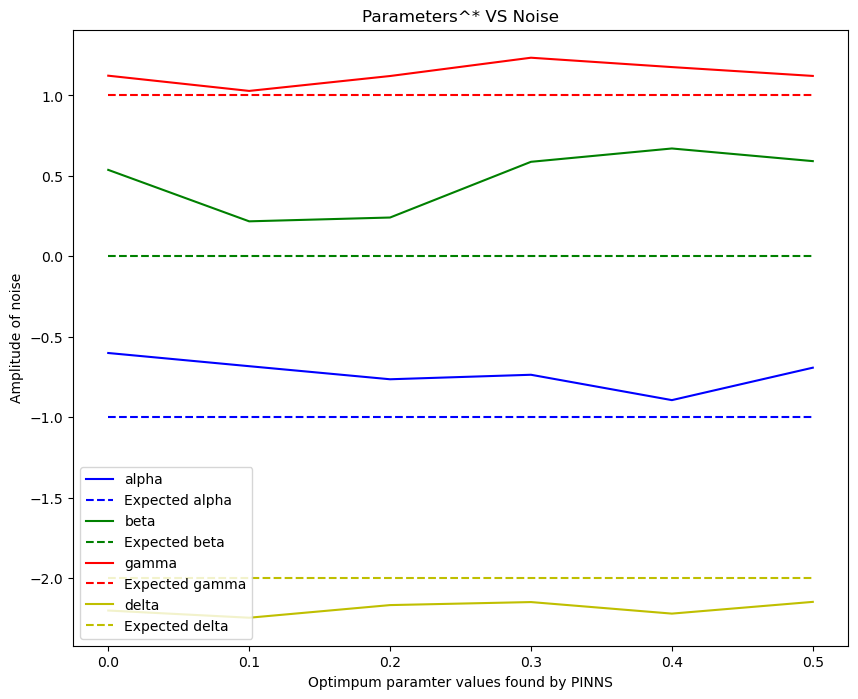

In [10]:
plt.figure(figsize=(10,8))

plt.plot(np.linspace(0,0.5,6), alpha_vals,'b', label = 'alpha')
plt.hlines(-1,0,0.5, color = 'b', linestyles = '--', label = 'Expected alpha')
plt.plot(np.linspace(0,0.5,6), beta_vals, 'g', label = 'beta')
plt.hlines(0,0,0.5, color = 'g', linestyles = '--', label = 'Expected beta')
plt.plot(np.linspace(0,0.5,6), gamma_vals,'r',  label = 'gamma')
plt.hlines(1,0,0.5, color = 'r', linestyles = '--', label = 'Expected gamma')
plt.plot(np.linspace(0,0.5,6), delta_vals,'y', label = 'delta')
plt.hlines(-2,0,0.5, color = 'y', linestyles = '--', label = 'Expected delta')

plt.xlabel('Optimpum paramter values found by PINNS')
plt.ylabel('Amplitude of noise')
plt.title('Parameters^* VS Noise')
plt.legend()

The value of the paramters learned by PINNS seems to be stable relative to the noise amplitude.

### Problem 4: Schrödinger equation

In this example you will need to find the eigenstates of the Schrödinger equation of the quantum harmonic oscillator $$-\frac{\hbar^2}{2m}\frac{d^2 \psi}{dx^2} + \frac{1}{2}mx^2\omega^2 \psi = E\psi. $$

The eigenvalue $E_n = \omega (n + 1/2)$ has the normalized eigenstate

$$
\psi_n(x) = \frac{\omega^{1/4}}{\pi^{1/4} \sqrt{2^n n!}}  H_n\left(\sqrt{\omega} x\right)e^{-\frac{\omega x^2}{2}}.
$$

We will take $\hbar = m=1$. The initial condition is $(\psi(0), \psi'(0)) =(1,0)$ is $n$ is even and $(0,1)$ if $n$ is odd.

* Learn $E$ from data. Try with different values of `num_pts` and `eps`.

In [12]:
from numpy.polynomial.hermite import hermval

In [79]:
n = 5
omega = 0.5
E_star = (n + 0.5) * omega
coeff = [0]*n + [1]

def psi_sol(x):
    return (
        1 / (2**n * np.math.factorial(n))**0.5
        * (omega / np.pi)**(1/4)
        * np.exp(-omega * x**2 / 2)
        * hermval(omega**0.5 * x, coeff)
    )

def gen_data(num_pts=100, eps=0.1):
    X = np.random.uniform(0, 10, [num_pts, 1])
    noise = eps*np.random.uniform(-1, 1, [num_pts, 1])
    return X, psi_sol(X) + noise

In [76]:
#PINNS Solution

x_min = 0; x_max = 10
geom = dde.geometry.TimeDomain(x_min, x_max)


def ic_begin(z,on_boundary):
    return dde.utils.isclose(z[0],x_min)

if n % 2 == 1:
    bc_psi_D = dde.icbc.DirichletBC (geom, lambda z: 0, ic_begin, component = 0)
    bc_psi_N = dde.icbc.NeumannBC(geom,lambda z: -1,ic_begin,component=0)
elif n % 2 == 0:
    bc_psi_D = dde.icbc.DirichletBC (geom, lambda z: 1, ic_begin, component = 0)
    bc_psi_N = dde.icbc.NeumannBC(geom,lambda z: 0,ic_begin,component=0)

def SH_ODE(eps=0.1, num_pts=100 , E_in = 5.):
    E = tf.Variable(E_in)
    
    points, Psis = gen_data(num_pts, eps)
    obs_psi = dde.icbc.PointSetBC(points, Psis, component = 0)

    bcs = [bc_psi_D, bc_psi_N, obs_psi]

    def SH_deepxde(z,y):
    
        psi = y[:, 0:1]
        x   = z[:, 0:1]
    
        dpsi_dx = dde.grad.jacobian(psi,z,0,0)
        d2psi_dx2 = dde.grad.jacobian(dpsi_dx,z,0,0)
    
        return (-1/2)*d2psi_dx2  + (1/2)*((omega*x)**2)*psi - E*psi



    data = dde.data.PDE(geom, SH_deepxde,bcs, 
                        num_domain = 1500,
                        num_boundary = 2,
                        num_test = 100,
                        anchors = points
                       )
    
    net = dde.nn.FNN([1] + [60]*4 + [1], 'tanh', 'Glorot uniform')
    parameters = dde.callbacks.VariableValue([E], period = 200)

    model = dde.Model(data, net)
    model.compile('adam', lr = 0.01, metrics = [])
    losshistory, train_state = model.train(iterations = 2000, callbacks = [parameters])
    
    return parameters.value

In [80]:
out = []
nums = [100,150,200]
nois = [0.1, 0.3, 0.5, 0.7]
for i in range(3):
    Es = []
    for eps in nois:
        Es.append(SH_ODE(eps=eps, num_pts=nums[i] , E_in = 2.5)[0])
    out.append(Es)


Compiling model...
Building feed-forward neural network...
'build' took 0.247248 s

'compile' took 3.534623 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [5.41e-01, 1.00e+00, 4.06e-05, 5.81e-02]    [5.22e-01, 1.00e+00, 4.06e-05, 5.81e-02]    []  
0 [2.50e+00]
200 [2.57e+00]
400 [2.53e+00]
600 [2.48e+00]
800 [2.43e+00]
1000      [3.22e-02, 4.94e-03, 8.61e-05, 3.82e-02]    [3.21e-02, 4.94e-03, 8.61e-05, 3.82e-02]    []  
1000 [2.36e+00]
1200 [2.28e+00]
1400 [2.22e+00]
1600 [2.16e+00]
1800 [2.13e+00]
2000      [2.55e-02, 3.54e-03, 3.69e-05, 3.50e-02]    [2.58e-02, 3.54e-03, 3.69e-05, 3.50e-02]    []  
2000 [2.09e+00]

Best model at step 2000:
  train loss: 6.41e-02
  test loss: 6.43e-02
  test metric: []

'train' took 82.109956 s

Compiling model...
Building feed-forward neural network...
'build' took 0.198978 s

'compile' took 5.007013 s

Training model...

Step      Train loss                

2000 [2.16e+00]

Best model at step 2000:
  train loss: 1.04e-01
  test loss: 1.05e-01
  test metric: []

'train' took 105.054256 s

Compiling model...
Building feed-forward neural network...
'build' took 0.389193 s

'compile' took 7.199164 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.94e+00, 1.00e+00, 7.04e-02, 3.77e-01]    [3.90e+00, 1.00e+00, 7.04e-02, 3.77e-01]    []  
0 [2.50e+00]
200 [2.56e+00]
400 [2.51e+00]
600 [2.45e+00]
800 [2.38e+00]
1000      [3.62e-02, 6.76e-03, 4.07e-05, 1.19e-01]    [3.56e-02, 6.76e-03, 4.07e-05, 1.19e-01]    []  
1000 [2.29e+00]
1200 [2.20e+00]
1400 [2.12e+00]
1600 [2.06e+00]
1800 [2.00e+00]
2000      [3.46e-02, 5.02e-03, 5.53e-06, 1.13e-01]    [3.42e-02, 5.02e-03, 5.53e-06, 1.13e-01]    []  
2000 [1.95e+00]

Best model at step 2000:
  train loss: 1.52e-01
  test loss: 1.52e-01
  test metric: []

'train' took 96.807777 s

Compiling model...
Building feed-

In the follwoing we plot the results for $n=2$ and $n=5$. Number of observations are [100,150,200], and value for noise amplitudes are [0.1, 0.3, 0.5, 0.7]

For $n=5$ the values of E learned by the NN are less sensitive to noise amplitudes, but hteir value is very different with the expected value of $E^*$.

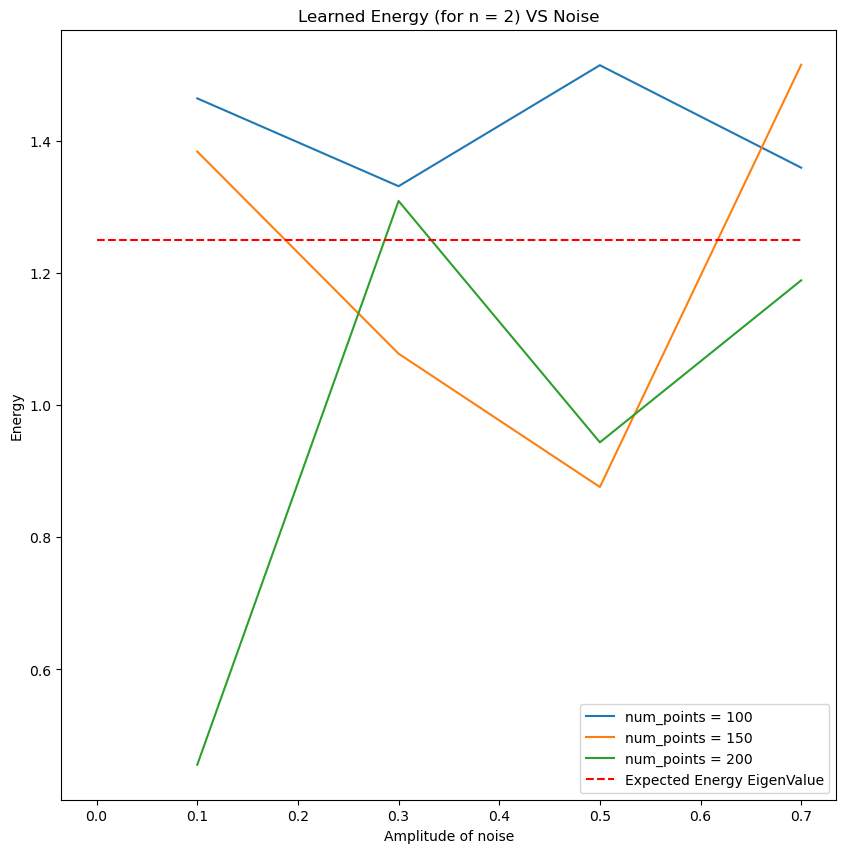

In [78]:
plt.figure(figsize=(10,10))
nums = [100,150,200]
for i in range(3):
    
    plt.plot(nois, out[i], label = 'num_points = {}'.format(nums[i]))

plt.hlines(E_star, 0, 0.7, color = 'r',linestyles = '--', label='Expected Energy EigenValue')
plt.ylabel('Energy')
plt.xlabel('Amplitude of noise')
plt.title('Learned Energy (for n = {}) VS Noise'.format(2))
plt.legend()

plt.show()

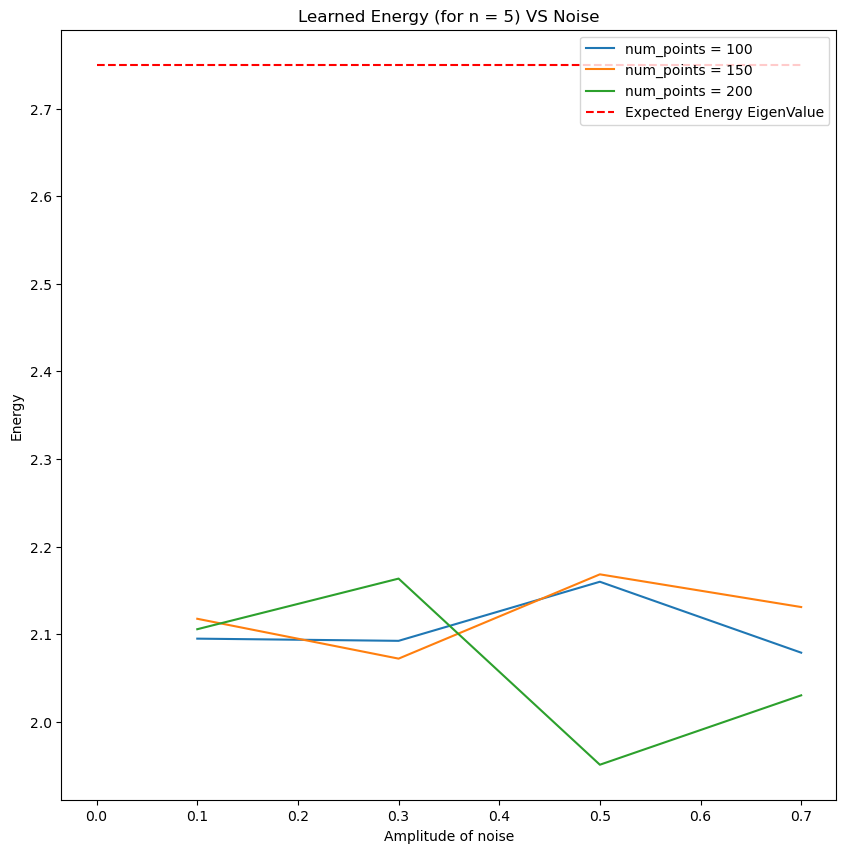

In [81]:
plt.figure(figsize=(10,10))
nums = [100,150,200]
for i in range(3):
    
    plt.plot(nois, out[i], label = 'num_points = {}'.format(nums[i]))

plt.hlines(E_star, 0, 0.7, color = 'r',linestyles = '--', label='Expected Energy EigenValue')
plt.ylabel('Energy')
plt.xlabel('Amplitude of noise')
plt.title('Learned Energy (for n = {}) VS Noise'.format(5))
plt.legend()

plt.show()